In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

2024-11-26 12:18:01.638790: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-26 12:18:01.721648: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-26 12:18:01.751003: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-26 12:18:01.922709: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Data Exploration

In [2]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [3]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [4]:
print(f"Train Image Size: {train_images.shape}")
print(f"Train label Size: {train_labels.shape}")

print(f"Test Image Size: {test_images.shape}")
print(f"Test label Size: {test_labels.shape}")

Train Image Size: (60000, 28, 28)
Train label Size: (60000,)
Test Image Size: (10000, 28, 28)
Test label Size: (10000,)


In [5]:
print(f"Min value: {train_images[0].min()}\nMax Value: {train_images[0].max()}")

Min value: 0
Max Value: 255


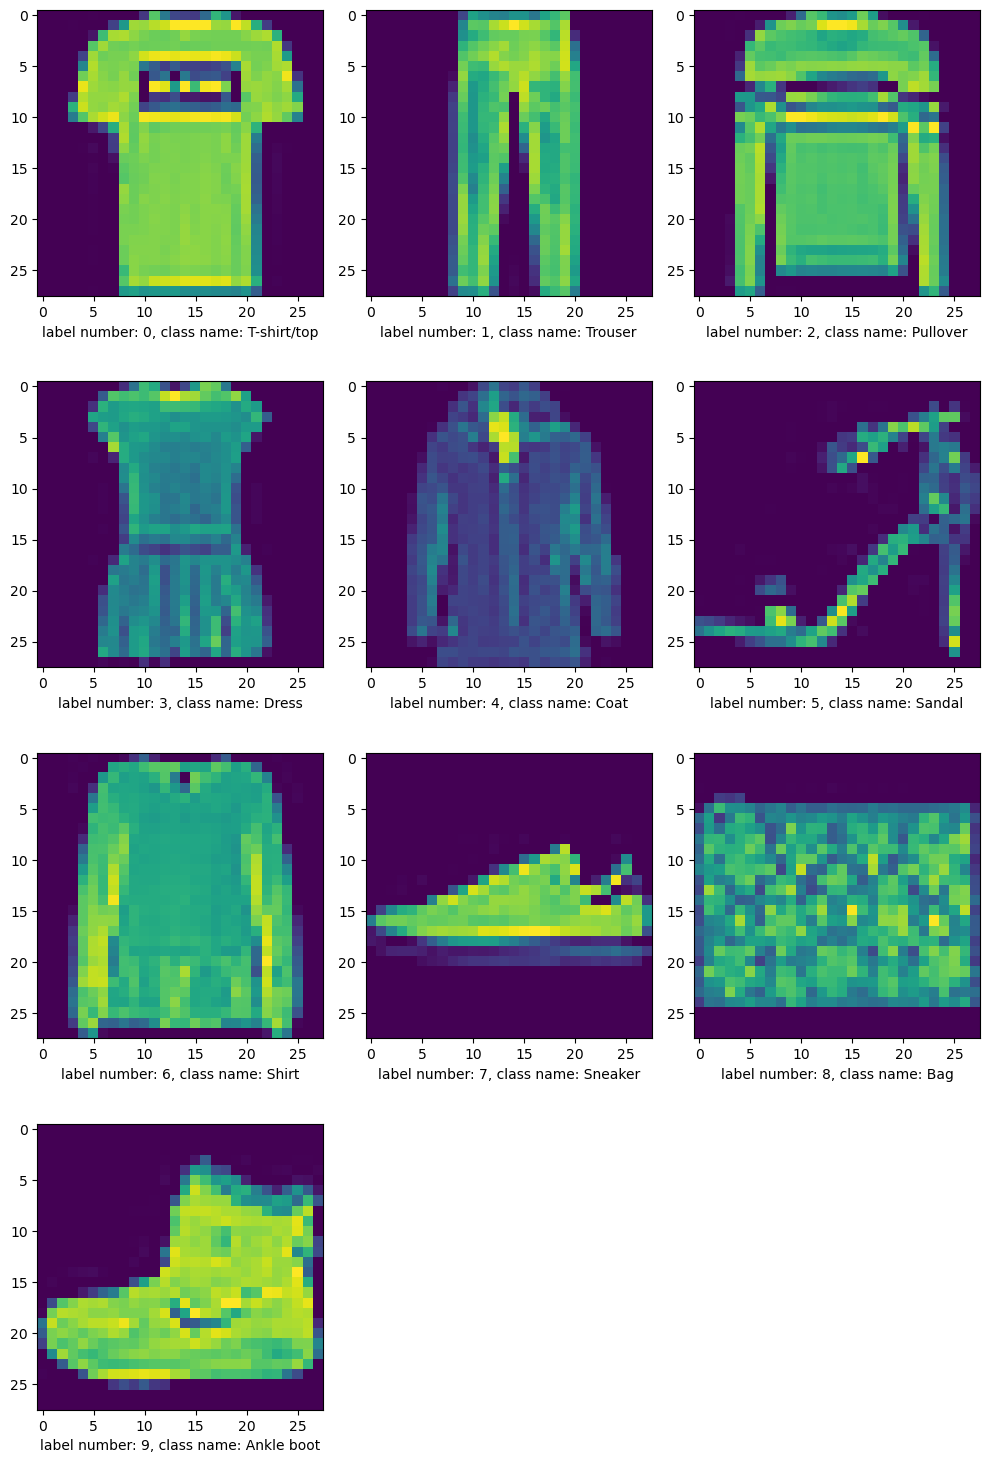

In [6]:
# Plotting images for each labels
unique_values, indices = np.unique(train_labels, return_index=True)

fig, axs= plt.subplots(4, 3, figsize=(10, 15))
axs= axs.flatten()
for (unique_value, index) in (zip(unique_values, indices)):
    axs[unique_value].imshow(train_images[index])
    axs[unique_value].set_xlabel(f"label number: {unique_value}, class name: {class_names[unique_value]}")

# Leave the last two plots empty
for i in range(10, 12):  # Optional: Remove axes
    axs[i].axis('off')


plt.tight_layout()
plt.show()

In [7]:
#Identify the count of images of each categories.
# np.c(train_labels)
import pandas as pd
unique_values, counts = np.unique(train_labels, return_counts=True)

train_image_label_df = pd.DataFrame( data = {'Categories Name': class_names, 'Label Id':unique_values, "Count": counts})
train_image_label_df

,Categories Name,Label Id,Count
0,T-shirt/top,0,6000
1,Trouser,1,6000
2,Pullover,2,6000
3,Dress,3,6000
4,Coat,4,6000
5,Sandal,5,6000
6,Shirt,6,6000
7,Sneaker,7,6000
8,Bag,8,6000
9,Ankle boot,9,6000


In [8]:
#Normalization in the range of [0 - 1]
train_images = train_images / 255.0

test_images = test_images / 255.0

In [9]:
# One hot encoding, 
encoder = OneHotEncoder(sparse_output= False)
train_labels_onehot = encoder.fit_transform(train_labels.reshape(-1, 1))
test_labels_onehot = encoder.transform(test_labels.reshape(-1, 1))

- If we want to use one hot encoded label data then we must use **Categorical Cross Entropy** as loss function. 
- If we use normal label data then we can use **Sparce Categorical Cross Entropy** as loss function.

# Model Building And Evaluation:

In [10]:
# Checking whether GPU or CPU used for model training
gpu_devices = tf.config.list_physical_devices('GPU')

if not gpu_devices:
    print("TensorFlow is using the CPU.")
else:
    print(f"TensorFlow is using the following GPU(s): {gpu_devices}")

TensorFlow is using the following GPU(s): [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


I0000 00:00:1732645093.803502    6745 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1732645094.195980    6745 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1732645094.197103    6745 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


In [11]:
# This is done for the reproducability of the model
seed_value = 42
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

## Common Methods Used In Model Evaluations

In [12]:
# Method to plot train and validation accuracy and loss over epoches.
def PlotTrainAndValidationAccuracyAndLoss(nn_model_history: tf.keras.callbacks.History, model_name: str):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    sns.lineplot(x=np.array(nn_model_history.epoch) + 1, y= nn_model_history.history['accuracy'], label='Train', ax = axs[0])
    sns.lineplot(x=np.array(nn_model_history.epoch) + 1, y= nn_model_history.history['val_accuracy'], label='Validation', ax = axs[0])
    axs[0].set_title(f'{model_name} accuracy')
    axs[0].set_ylabel('accuracy')
    axs[0].set_xlabel('epoch')
    axs[0].legend(loc='upper left')

    sns.lineplot(x=np.array(nn_model_history.epoch) + 1, y= nn_model_history.history['loss'], label='Train', ax = axs[1])
    sns.lineplot(x=np.array(nn_model_history.epoch) + 1, y= nn_model_history.history['val_loss'], label='Validation', ax = axs[1])
    axs[1].set_title(f'{model_name} loss')
    axs[1].set_ylabel('loss')
    axs[1].set_xlabel('epoch')
    axs[1].legend(loc='upper left')

    plt.tight_layout()
    plt.show()

In [13]:
#Model Evaluation function
def EvaluateNeuralNetworkModel(nn_model : tf.keras.Sequential, test_images: np.ndarray, test_labels: np.ndarray, test_labels_onehot: np.ndarray, model_name: str):
    model_test_loss, model_test_acc = nn_model.evaluate(test_images,  test_labels_onehot, verbose=2)

    print(f'\nTest accuracy for {model_name}: {model_test_acc:.4f}\n')
    print(f"Test loss for {model_name}: {model_test_loss:.4f}\n")
    
    model_prediction_result_softmax= nn_model.predict(test_images,batch_size= 32)

    model_test_label_pred = np.argmax(model_prediction_result_softmax, axis=1)  # Predicted labels

    print(f"first 10 predicted outputs: {model_test_label_pred[:10]}\n")
    print(f"first 10 true outputs: {test_labels[:10]}\n")

    # Print a classification report for neural network classification model
    model_classification_report = (classification_report(test_labels, model_test_label_pred))
    print(f"Classification report for {model_name} :\n{model_classification_report}")

    # Print a confusion matrix for neural network on test dataset

    model_confusion_matrix= (confusion_matrix(test_labels, model_test_label_pred))

    sns.heatmap(data= model_confusion_matrix,fmt='g', annot= True, cmap= "crest")
    plt.title(f"Confusion Matrix for the {model_name} on test dataset")
    plt.tight_layout()
    plt.xlabel("Predicted Values")
    plt.ylabel("Actual Values")
    plt.show()

    return model_prediction_result_softmax
    

In [14]:
# Model committee by averaging prediction of models: 
def ModelCommitteeAnalysis(model_result_softmax_list: list, test_labels: np.ndarray, model_name: str, is_object_return= False):
    model_committee_softmax = np.mean(model_result_softmax_list, axis= 0)
    model_committee_test_label_pred = np.argmax(model_committee_softmax, axis=1)  # Predicted labels

    loss = tf.keras.losses.CategoricalCrossentropy()(test_labels_onehot, model_committee_softmax).numpy()
    accuracy = accuracy_score(test_labels, model_committee_test_label_pred)

    print(f"Loss for the {model_name} on test dataset: {loss:.4f}")
    print(f"Accuracyensemble for the {model_name} on test dataset: {accuracy:.4f}")

    print(f"first 10 predicted outputs using committee by averaging predictions: {model_committee_test_label_pred[:10]}\n")
    print(f"first 10 true outputs: {test_labels[:10]}\n")

    # Print a classification report for committee of shallow neural network classification models
    model_committee_classification_report = (classification_report(test_labels, model_committee_test_label_pred))
    print(model_committee_classification_report)

    # Print a confusion matrix for committee of neural network on test dataset

    model_committee_confusion_matrix= (confusion_matrix(test_labels, model_committee_test_label_pred))

    sns.heatmap(data= model_committee_confusion_matrix,fmt='g', annot= True, cmap= "vlag")
    plt.title(f"Confusion Matrix for the {model_name} neural network committee on test dataset")
    plt.tight_layout()
    plt.xlabel("Predicted Values")
    plt.ylabel("Actual Values")
    plt.show()

    if(is_object_return):
        return model_committee_softmax, model_committee_test_label_pred


## Shallow Neural Network

### shallow neural network 1

**Model Architecture**:
- 28 * 28 pixels images are provided as input to the model. 
- First step is to flatten the 2D inputs into 1D input parameters. 
- After Flatten, It is fed to the fist Dense layer. It contains 128 neurons and **relu** as activation function.
- It has output layers with 10 neurons. **Softmax** activation function is used in output layer.
- For the optimization of the model, We are using **ADAM** optimizer.
- For the loss calculation of the model, We are using **Categorical** Cross Entropy*.
- As an additional performance metrices, we are using **Accuracy** to evaluate the model during training. 

In [33]:
#Shallow Neural Network Model 1
shallow_nn_model1 = tf.keras.Sequential([
    tf.keras.layers.Input(shape= (28, 28)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

shallow_nn_model1.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy,
              metrics=['accuracy'])

shallow_nn1_history = shallow_nn_model1.fit(
    train_images, 
    train_labels_onehot, 
    epochs=100, 
    validation_split= 0.2, 
    batch_size= 32)

Epoch 1/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.7711 - loss: 0.6507 - val_accuracy: 0.8433 - val_loss: 0.4420
Epoch 2/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8575 - loss: 0.3994 - val_accuracy: 0.8601 - val_loss: 0.3914
Epoch 3/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8743 - loss: 0.3507 - val_accuracy: 0.8692 - val_loss: 0.3632
Epoch 4/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8846 - loss: 0.3213 - val_accuracy: 0.8733 - val_loss: 0.3562
Epoch 5/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8904 - loss: 0.3012 - val_accuracy: 0.8728 - val_loss: 0.3558
Epoch 6/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.8954 - loss: 0.2835 - val_accuracy: 0.8784 - val_loss: 0.3437
Epoch 7/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9010 - loss: 0.2671 - val_accuracy: 0.8777 - val_loss: 0.3489
Epoch 8/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9052 - loss: 

KeyboardInterrupt: 

Model is trained over 100 epoches and 20% of the training dataset is separated as the validation set. For this model, We used batch size of 32. 

In [ ]:
shallow_nn_model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 305,312 (1.16 MB)

 Trainable params: 101,770 (397.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 203,542 (795.09 KB)

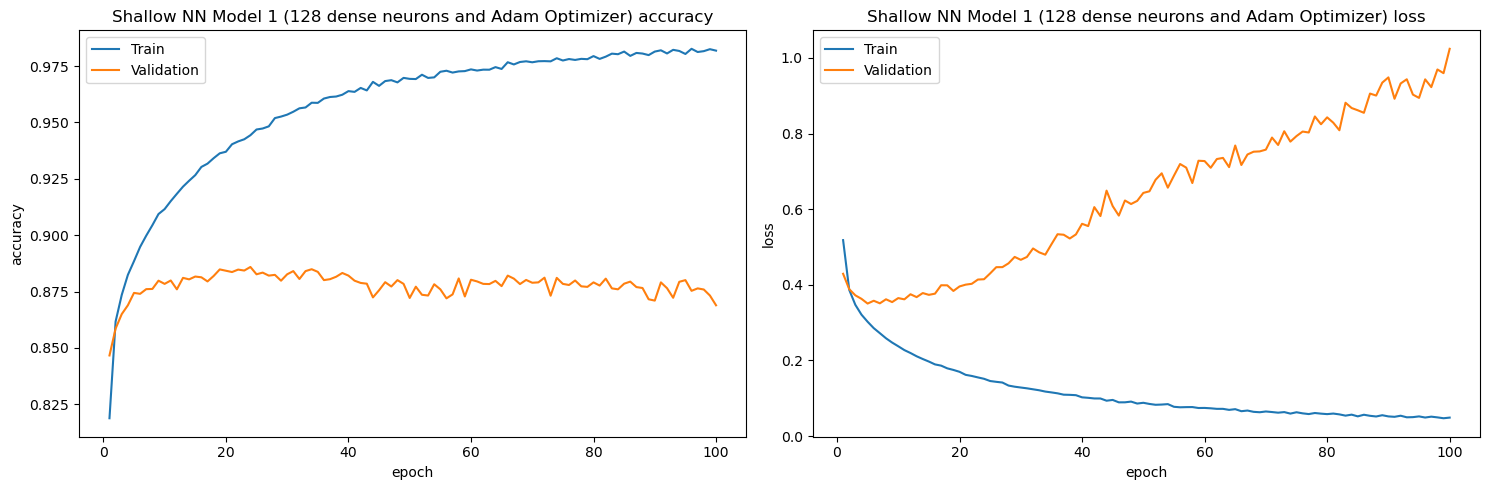

In [ ]:
PlotTrainAndValidationAccuracyAndLoss(shallow_nn1_history, "Shallow NN Model 1 (128 dense neurons and Adam Optimizer)")


Above plot shows the change in accuracy and loss of both training data and validation data over the epoches. 

- **Accuracy**
  - If we look into the accracy of the train data set, it keeps improving over 100 epoches and it reached to the accuracy of 0.9852.
  - But in validation data set, accuracy increased initially but later it did not change over the epoches and maintain the validation accuracy of 0.8698. 
  - There is huge gap in training accuracy and validation accuracy. This is the case of over fitting. Model is able to predict the output accuratly on training dataset but not on validation dataset. 

- **Categorical Cross EntropyLoss**
  - Training loss started from the value of around 0.6569 and it kept decreasing and after around 40 epochs, loss started maintaing similar loss values. And finally at 100 epoches it showed the loss of 0.0425 for training data set. 
  - Similary For the validation dataset, loss values initially decreases but after few epochs it started increasing and after 100 epochs, it had the validation loss of 1.0076. Validation loss has huge deviation from training loss which showed that model is facing the problem of overfitting.

313/313 - 0s - 762us/step - accuracy: 0.8622 - loss: 1.0737

Test accuracy for Shallow Neural Network 1: 0.8622

Test loss for Shallow Neural Network 1: 1.0737

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
first 10 predicted outputs: [9 2 1 1 6 1 4 6 5 7]

first 10 true outputs: [9 2 1 1 6 1 4 6 5 7]

Classification report for Shallow Neural Network 1 :
              precision    recall  f1-score   support

           0       0.87      0.70      0.78      1000
           1       0.99      0.96      0.98      1000
           2       0.78      0.73      0.75      1000
           3       0.90      0.84      0.87      1000
           4       0.74      0.83      0.78      1000
           5       0.97      0.95      0.96      1000
           6       0.59      0.73      0.66      1000
           7       0.95      0.95      0.95      1000
           8       0.97      0.95      0.96      1000
           9       0.94      0.97      0.96      1000

    accuracy                           0.86     10

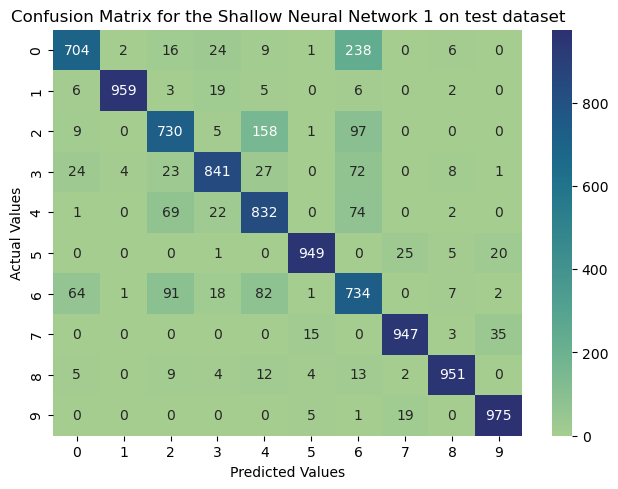

In [ ]:
snn1_prediction_result_softmax = EvaluateNeuralNetworkModel(shallow_nn_model1, test_images, test_labels, test_labels_onehot, "Shallow Neural Network 1")

Class 6 "Shirt" is misclassified for the most of the time. It is mostly confused with class 0 "T-shirt/top" and then with class 2 "Pullover" and then with class 5 "Coat".

### Shallow Neural Network Model 2

In this model, 
- We used 256 neurons in dense layer with **relu** activation function. 
- We used Adam Optimizer with initial learning rate of 0.001 as the optimization function. 
- While training model we use the batch size of 64. 

Other than that all architectural design is similar to the Shallow Neural Network 1. 

In [ ]:
#Shallow Neural Network Model 2
shallow_nn_model2 = tf.keras.Sequential([
    tf.keras.layers.Input(shape= (28, 28)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

shallow_nn_model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy,
              metrics=['accuracy'])

shallow_nn2_history = shallow_nn_model2.fit(
    train_images, 
    train_labels_onehot, 
    epochs=100, 
    validation_split= 0.2, 
    batch_size= 64)

Epoch 1/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7724 - loss: 0.6546 - val_accuracy: 0.8556 - val_loss: 0.4167
Epoch 2/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8594 - loss: 0.4010 - val_accuracy: 0.8654 - val_loss: 0.3760
Epoch 3/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8757 - loss: 0.3507 - val_accuracy: 0.8726 - val_loss: 0.3547
Epoch 4/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8855 - loss: 0.3196 - val_accuracy: 0.8771 - val_loss: 0.3458
Epoch 5/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8921 - loss: 0.2986 - val_accuracy: 0.8792 - val_loss: 0.3410
Epoch 6/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8975 - loss: 0.2813 - val_accuracy: 0.8798 - val_loss: 0.3382
Epoch 7/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9030 - loss: 0.2657 - val_accuracy: 0.8819 - val_loss: 0.3373
Epoch 8/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9066 - loss: 0.2524 - val_accu

In [ ]:
shallow_nn_model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 610,592 (2.33 MB)

 Trainable params: 203,530 (795.04 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 407,062 (1.55 MB)

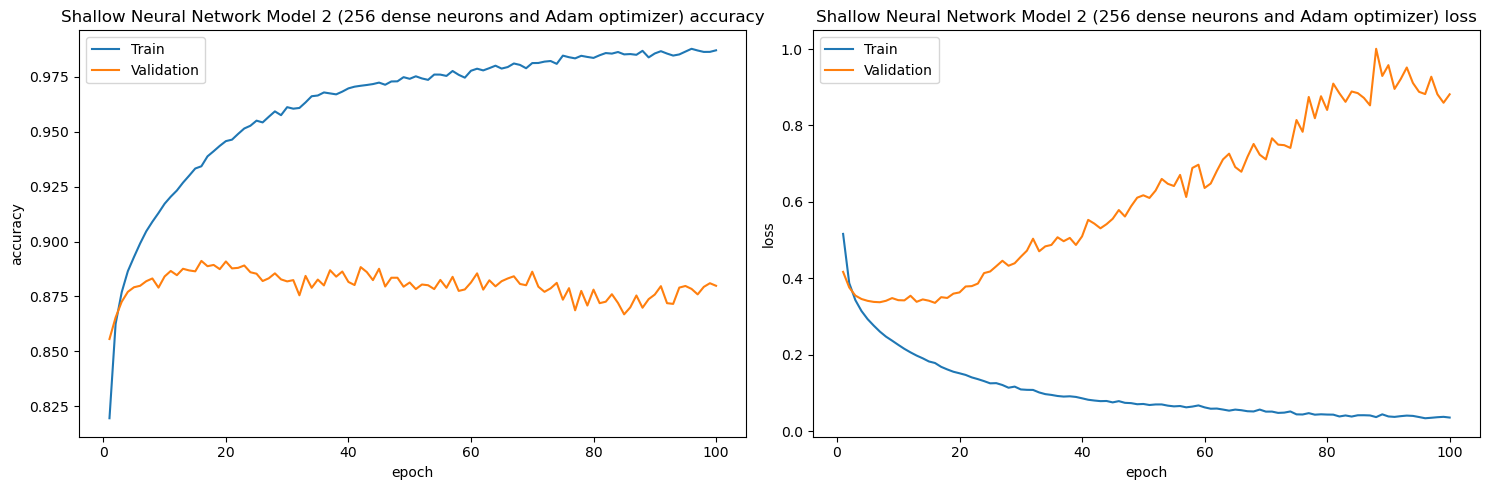

In [ ]:
PlotTrainAndValidationAccuracyAndLoss(shallow_nn2_history, "Shallow Neural Network Model 2 (256 dense neurons and Adam optimizer)")

Above plot shows the change in accuracy and loss of both training data and validation data over the epoches. 

- **Accuracy**
  - Training Accuracy: 0.9881.
  - Validation Accuracy of 0.8733. 
  - Overfitting 

- **Categorical Cross EntropyLoss**
  - Training Loss: 0.0324
  - Validation Loss: 0.9158

313/313 - 0s - 828us/step - accuracy: 0.8725 - loss: 0.9626

Test accuracy for Shallow Neural Network 2: 0.8725

Test loss for Shallow Neural Network 2: 0.9626

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step
first 10 predicted outputs: [9 2 1 1 6 1 4 6 5 7]

first 10 true outputs: [9 2 1 1 6 1 4 6 5 7]

Classification report for Shallow Neural Network 2 :
              precision    recall  f1-score   support

           0       0.87      0.74      0.80      1000
           1       0.98      0.98      0.98      1000
           2       0.80      0.74      0.77      1000
           3       0.90      0.88      0.89      1000
           4       0.79      0.79      0.79      1000
           5       0.97      0.96      0.96      1000
           6       0.61      0.77      0.68      1000
           7       0.93      0.96      0.95      1000
           8       0.98      0.95      0.97      1000
           9       0.95      0.95      0.95      1000

    accuracy                           0.87     10

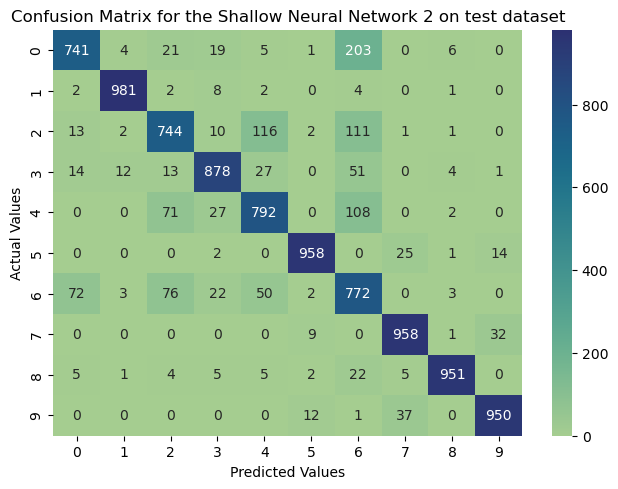

In [ ]:
snn2_prediction_result_softmax = EvaluateNeuralNetworkModel(shallow_nn_model2, test_images, test_labels, test_labels_onehot, "Shallow Neural Network 2")

### Shallow Neural Network Model 3

In this model, 
- I splitted the one dense layer of 256 neurons into the 2 dense layers with 128 neurons in each layer.
- Optimization function is also changed from Adam Optimizer to the SGD Optimizer. 

In [34]:
#Shallow Neural Network Model 3
shallow_nn_model3 = tf.keras.Sequential([
    tf.keras.layers.Input(shape= (28, 28)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])
shallow_nn_model3.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.005),
              loss=tf.keras.losses.CategoricalCrossentropy,
              metrics=['accuracy'])

shallow_nn3_history = shallow_nn_model3.fit(train_images, train_labels_onehot, epochs=100, validation_split= 0.2, batch_size= 64)

Epoch 1/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.5420 - loss: 1.5119 - val_accuracy: 0.7595 - val_loss: 0.7486
Epoch 2/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.7718 - loss: 0.7089 - val_accuracy: 0.7986 - val_loss: 0.6113
Epoch 3/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8039 - loss: 0.5929 - val_accuracy: 0.8148 - val_loss: 0.5538
Epoch 4/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8197 - loss: 0.5389 - val_accuracy: 0.8262 - val_loss: 0.5204
Epoch 5/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8287 - loss: 0.5068 - val_accuracy: 0.8305 - val_loss: 0.4984
Epoch 6/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8360 - loss: 0.4848 - val_accuracy: 0.8335 - val_loss: 0.4822
Epoch 7/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8407 - loss: 0.4686 - val_accuracy: 0.8361 - val_loss: 0.4697
Epoch 8/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8447 - loss: 0.4556 - val_accu

In [35]:
shallow_nn_model3.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_6 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 235,148 (918.55 KB)

 Trainable params: 235,146 (918.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

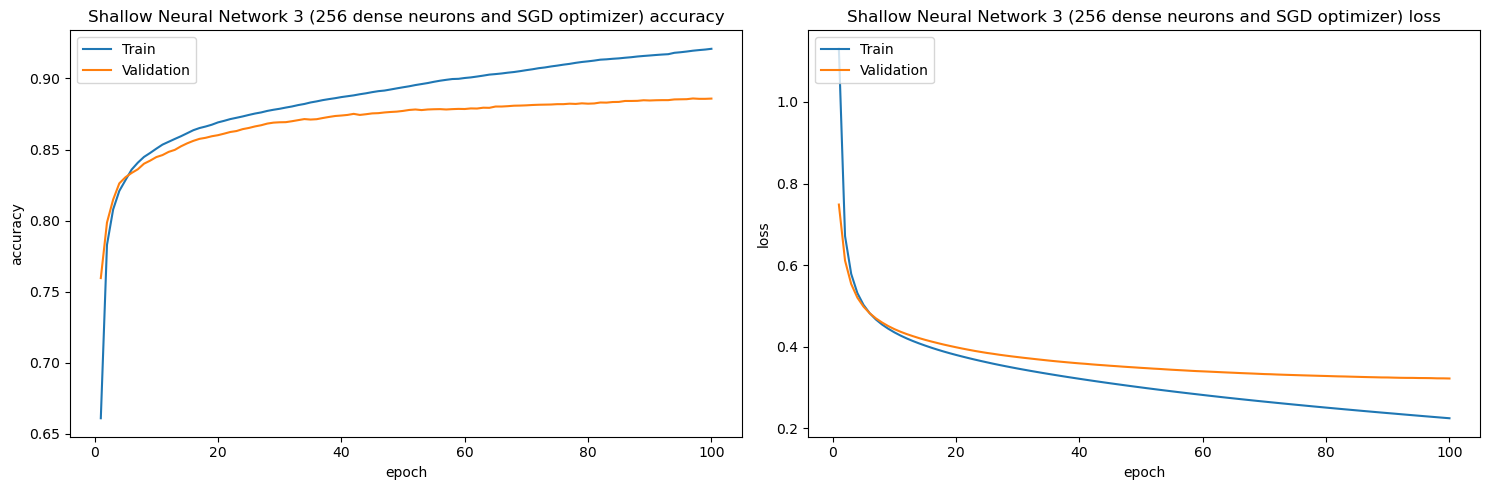

In [36]:
PlotTrainAndValidationAccuracyAndLoss(shallow_nn3_history, "Shallow Neural Network 3 (256 dense neurons and SGD optimizer)")

Above plot shows the change in accuracy and loss of both training data and validation data over the epoches. 

- **Accuracy**
  - Training Accuracy: 0.9136.
  - Validation Accuracy of 0.8845. 
  - Overfitting 

- **Categorical Cross EntropyLoss**
  - Training Loss: 0.2454
  - Validation Loss: 0.3316

313/313 - 3s - 9ms/step - accuracy: 0.8754 - loss: 0.3462

Test accuracy for Shallow Neural Network 3: 0.8754

Test loss for Shallow Neural Network 3: 0.3462

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
first 10 predicted outputs: [9 2 1 1 6 1 4 6 5 7]

first 10 true outputs: [9 2 1 1 6 1 4 6 5 7]

Classification report for Shallow Neural Network 3 :
              precision    recall  f1-score   support

           0       0.87      0.76      0.81      1000
           1       0.99      0.97      0.98      1000
           2       0.77      0.81      0.79      1000
           3       0.85      0.90      0.87      1000
           4       0.82      0.79      0.80      1000
           5       0.97      0.95      0.96      1000
           6       0.68      0.72      0.70      1000
           7       0.91      0.96      0.94      1000
           8       0.96      0.96      0.96      1000
           9       0.97      0.93      0.95      1000

    accuracy                           0.88     10000


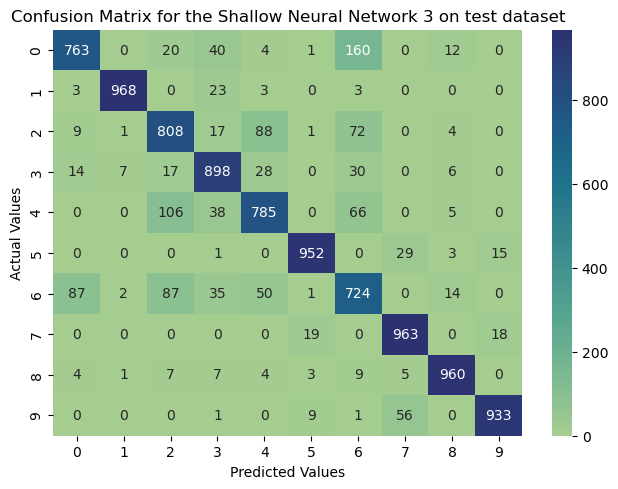

In [37]:
snn3_prediction_result_softmax = EvaluateNeuralNetworkModel(shallow_nn_model3, test_images, test_labels, test_labels_onehot, "Shallow Neural Network 3")

## Simple Convolutional Neural Network

### Basic Convolutional Neural Network 1

**Model Architecture**
- Input layer accepts 28* 28 * 1 size of image. Here, image contains 28 pixels in width and 28 pixels in height and it has channel depth of 1. 
- Second layer is **Conv2d** layer. It contains 32 filters which means it generates 32 layers. Each filter has a kernel size of 3 * 3 that means it covers 3 pixel in width and 3 pixels in height at a time. **ReLU** is used as activation function for this layer. 
- Output from COnv2D layer ispassed into the max pooling layer. It has pool size of 2 * 2. This means it pick maximum output from each 2 * 2 grid in each layer. 
- After that, output from max pooling layer is flatten which is required to feed into the fully connected layer.
- Fully connected layer contains 128 neurons (nodes) with ReLU as activation function. 
- Output layer contains 10 neurons. Each neuron represents a category. 


In [17]:
simple_cnn_model1 = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (28, 28, 1)),
    tf.keras.layers.Conv2D(filters= 32, kernel_size= (3, 3), activation= "relu"),
    tf.keras.layers.MaxPool2D(pool_size= (2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units= 128, activation= "relu"),
    tf.keras.layers.Dense(10, activation='softmax')
])

simple_cnn_model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy,
              metrics=['accuracy'])

simple_cnn1_history = simple_cnn_model1.fit(train_images, train_labels_onehot, epochs=100, validation_split= 0.2, batch_size= 32)

Epoch 1/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.7943 - loss: 0.5667 - val_accuracy: 0.8858 - val_loss: 0.3289
Epoch 2/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8950 - loss: 0.2968 - val_accuracy: 0.8977 - val_loss: 0.2928
Epoch 3/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9124 - loss: 0.2454 - val_accuracy: 0.9034 - val_loss: 0.2754
Epoch 4/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9249 - loss: 0.2093 - val_accuracy: 0.9065 - val_loss: 0.2646
Epoch 5/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9358 - loss: 0.1775 - val_accuracy: 0.9052 - val_loss: 0.2764
Epoch 6/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9463 - loss: 0.1499 - val_accuracy: 0.9037 - val_loss: 0.2922
Epoch 7/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9555 - loss: 0.1251 - val_accuracy: 0.9034 - val_loss: 0.3086
Epoch 8/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9629 - loss: 

In [23]:
simple_cnn_model1.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 5408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       692,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,081,888 (7.94 MB)

 Trainable params: 693,962 (2.65 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,387,926 (5.29 MB)

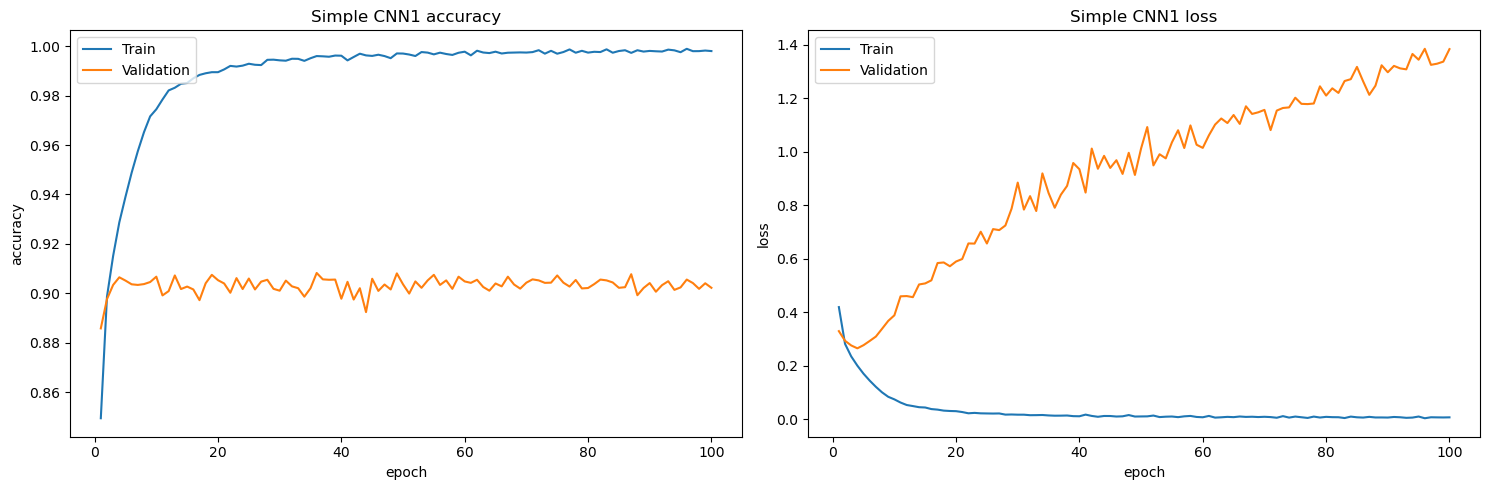

In [19]:
PlotTrainAndValidationAccuracyAndLoss(simple_cnn1_history, "Simple CNN1")

313/313 - 3s - 9ms/step - accuracy: 0.9001 - loss: 1.4174

Test accuracy for Simple CNN 1: 0.9001

Test loss for Simple CNN 1: 1.4174

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
first 10 predicted outputs: [9 2 1 1 6 1 4 6 5 7]

first 10 true outputs: [9 2 1 1 6 1 4 6 5 7]

Classification report for Simple CNN 1 :
              precision    recall  f1-score   support

           0       0.85      0.82      0.83      1000
           1       0.99      0.98      0.99      1000
           2       0.85      0.80      0.83      1000
           3       0.88      0.92      0.90      1000
           4       0.82      0.86      0.84      1000
           5       0.98      0.97      0.98      1000
           6       0.73      0.74      0.74      1000
           7       0.95      0.96      0.96      1000
           8       0.98      0.97      0.98      1000
           9       0.96      0.97      0.96      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90   

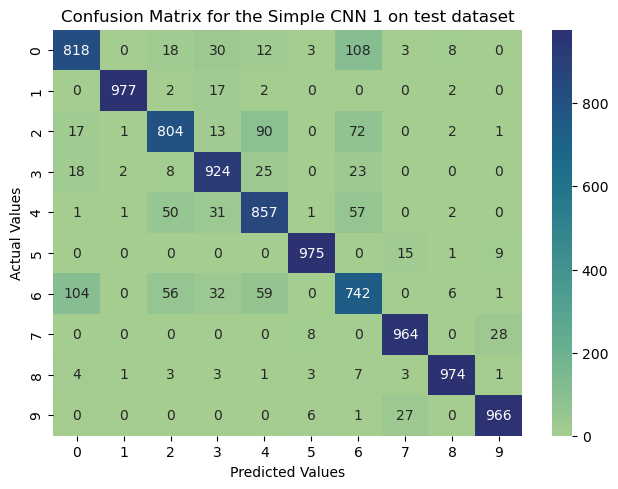

In [20]:
simple_cnn1_prediction_result_softmax = EvaluateNeuralNetworkModel(simple_cnn_model1, test_images, test_labels, test_labels_onehot, "Simple CNN 1")

### Simple Convolutional Neural Netowrk 2

In [ ]:
simple_cnn_model2 = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (28, 28, 1)),
    tf.keras.layers.Conv2D(filters= 64, kernel_size= (3, 3), activation= "relu"),
    tf.keras.layers.MaxPool2D(pool_size= (3, 3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units= 256, activation= "relu"),
    tf.keras.layers.Dense(10, activation='softmax')
])

simple_cnn_model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
              loss=tf.keras.losses.CategoricalCrossentropy,
              metrics=['accuracy'])

simple_cnn2_history = simple_cnn_model2.fit(train_images, train_labels_onehot, epochs=100, validation_split= 0.2, batch_size= 64)

Epoch 1/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.8051 - loss: 0.5367 - val_accuracy: 0.8864 - val_loss: 0.3112
Epoch 2/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8893 - loss: 0.2958 - val_accuracy: 0.8883 - val_loss: 0.3147
Epoch 3/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9054 - loss: 0.2494 - val_accuracy: 0.8863 - val_loss: 0.3290
Epoch 4/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9189 - loss: 0.2136 - val_accuracy: 0.8915 - val_loss: 0.3202
Epoch 5/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9289 - loss: 0.1866 - val_accuracy: 0.8907 - val_loss: 0.3360
Epoch 6/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9370 - loss: 0.1661 - val_accuracy: 0.8929 - val_loss: 0.3658
Epoch 7/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9443 - loss: 0.1493 - val_accuracy: 0.8900 - val_loss: 0.3936
Epoch 8/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9511 - loss: 0.1302 - val_acc

In [24]:
simple_cnn_model2.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 26, 26, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │     1,048,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,156,128 (12.04 MB)

 Trainable params: 1,052,042 (4.01 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,104,086 (8.03 MB)

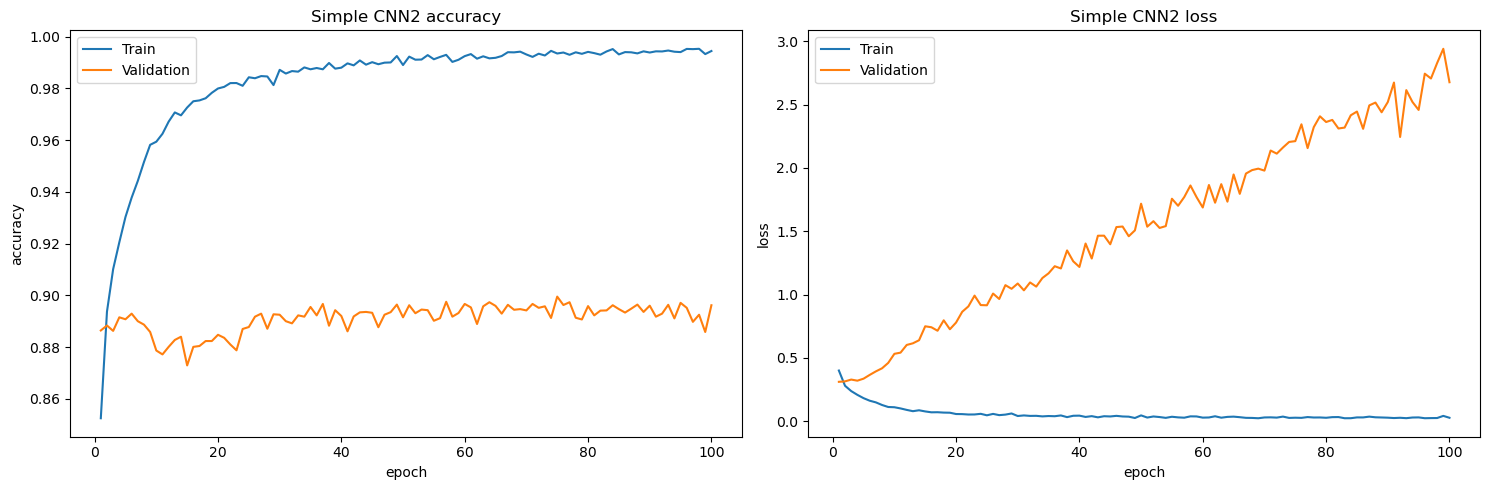

In [25]:
PlotTrainAndValidationAccuracyAndLoss(simple_cnn2_history, "Simple CNN2")

313/313 - 2s - 6ms/step - accuracy: 0.8915 - loss: 2.8663

Test accuracy for Simple CNN 2: 0.8915

Test loss for Simple CNN 2: 2.8663

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step
first 10 predicted outputs: [9 2 1 1 0 1 2 6 5 7]

first 10 true outputs: [9 2 1 1 6 1 4 6 5 7]

Classification report for Simple CNN 2 :
              precision    recall  f1-score   support

           0       0.83      0.82      0.82      1000
           1       0.99      0.98      0.98      1000
           2       0.80      0.82      0.81      1000
           3       0.93      0.88      0.90      1000
           4       0.82      0.82      0.82      1000
           5       0.98      0.97      0.98      1000
           6       0.68      0.71      0.70      1000
           7       0.95      0.98      0.97      1000
           8       0.98      0.97      0.98      1000
           9       0.97      0.96      0.97      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89   

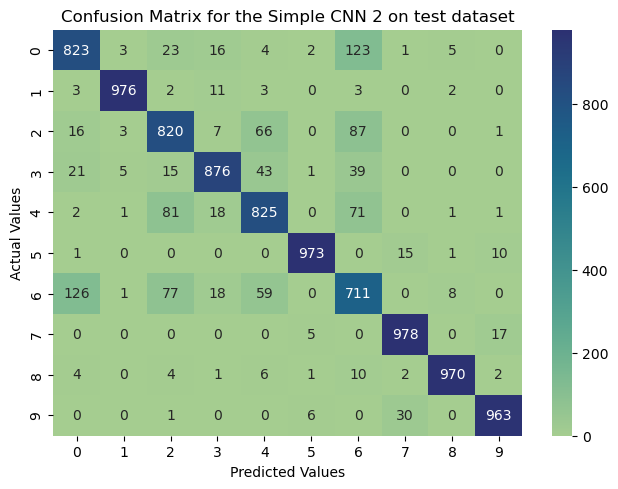

In [26]:
simple_cnn2_prediction_result_softmax = EvaluateNeuralNetworkModel(simple_cnn_model2, test_images, test_labels, test_labels_onehot, "Simple CNN 2")

### Simple Convolutional Neural Network 3

In [38]:
simple_cnn_model3 = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (28, 28, 1)),
    tf.keras.layers.Conv2D(filters= 32, kernel_size= (3, 3), activation= "relu"),
    tf.keras.layers.MaxPool2D(pool_size= (2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units= 256, activation= "tanh"),
    tf.keras.layers.Dense(10, activation='softmax')
])

simple_cnn_model3.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.005),
              loss=tf.keras.losses.CategoricalCrossentropy,
              metrics=['accuracy'])

simple_cnn3_history = simple_cnn_model3.fit(train_images, train_labels_onehot, epochs=100, validation_split= 0.2, batch_size= 64)

Epoch 1/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.5768 - loss: 1.4034 - val_accuracy: 0.7802 - val_loss: 0.6331
Epoch 2/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7877 - loss: 0.6117 - val_accuracy: 0.8067 - val_loss: 0.5419
Epoch 3/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8090 - loss: 0.5330 - val_accuracy: 0.8195 - val_loss: 0.5032
Epoch 4/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8223 - loss: 0.4954 - val_accuracy: 0.8282 - val_loss: 0.4798
Epoch 5/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8318 - loss: 0.4709 - val_accuracy: 0.8350 - val_loss: 0.4631
Epoch 6/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8387 - loss: 0.4530 - val_accuracy: 0.8407 - val_loss: 0.4498
Epoch 7/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8443 - loss: 0.4383 - val_accuracy: 0.8461 - val_loss: 0.4386
Epoch 8/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8493 - loss: 0.4262 - val_accu

In [39]:
simple_cnn_model3.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 5408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 256)            │     1,384,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,387,596 (5.29 MB)

 Trainable params: 1,387,594 (5.29 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

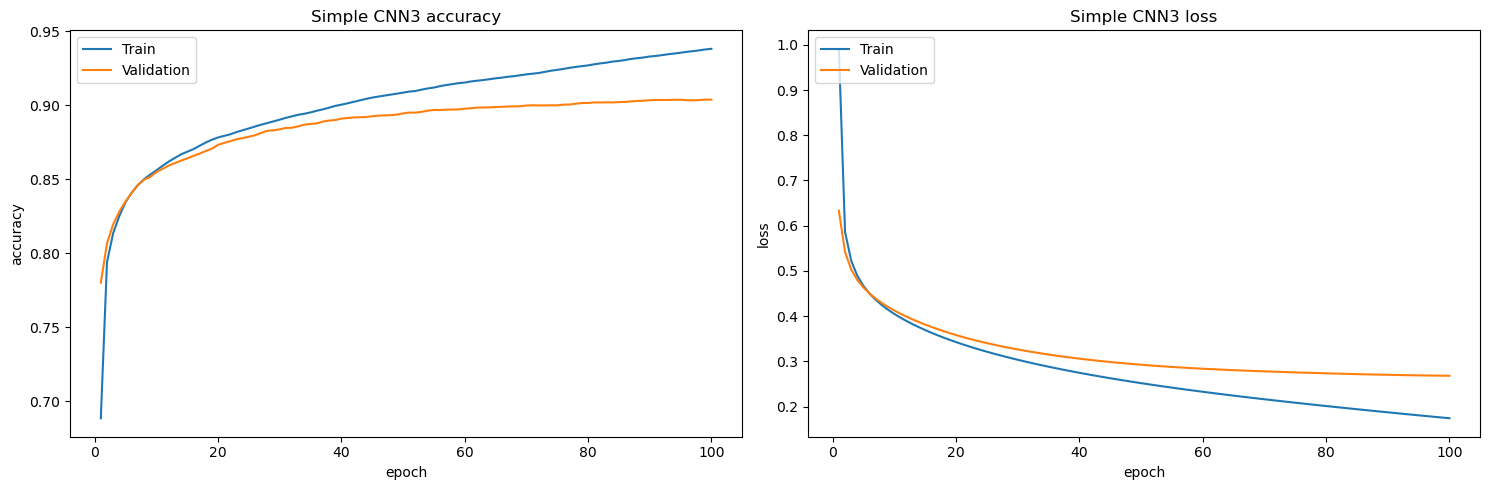

In [40]:
PlotTrainAndValidationAccuracyAndLoss(simple_cnn3_history, "Simple CNN3")

313/313 - 2s - 6ms/step - accuracy: 0.8959 - loss: 0.2829

Test accuracy for Simple CNN 3: 0.8959

Test loss for Simple CNN 3: 0.2829

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
first 10 predicted outputs: [9 2 1 1 6 1 4 6 5 7]

first 10 true outputs: [9 2 1 1 6 1 4 6 5 7]

Classification report for Simple CNN 3 :
              precision    recall  f1-score   support

           0       0.91      0.78      0.84      1000
           1       0.99      0.97      0.98      1000
           2       0.80      0.87      0.83      1000
           3       0.89      0.90      0.90      1000
           4       0.87      0.79      0.82      1000
           5       0.97      0.97      0.97      1000
           6       0.69      0.78      0.73      1000
           7       0.94      0.96      0.95      1000
           8       0.97      0.97      0.97      1000
           9       0.97      0.95      0.96      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90   

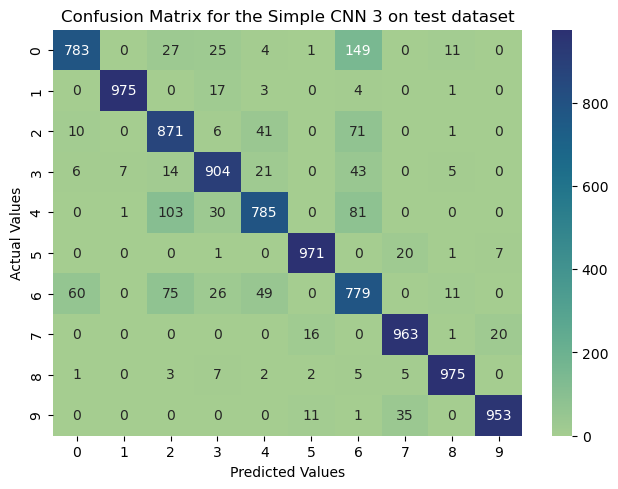

In [41]:
simple_cnn3_prediction_result_softmax = EvaluateNeuralNetworkModel(simple_cnn_model3, test_images, test_labels, test_labels_onehot, "Simple CNN 3")

### Simple CNN Model with Data Augmentation, Droplet and Batch Normalization

In [304]:
#Shallow Neural Network Model 6

simple_cnn_model4 = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (28, 28, 1)),
    tf.keras.layers.Conv2D(filters= 32, kernel_size= (3, 3), activation= "relu"),
    tf.keras.layers.Dropout(0.05),
    tf.keras.layers.MaxPool2D(pool_size= (2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(units= 256, activation= "tanh"),
    tf.keras.layers.Dense(10, activation='softmax')
])

simple_cnn_model4.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.005),
              loss=tf.keras.losses.CategoricalCrossentropy,
              metrics=['accuracy'])

simple_cnn4_history = simple_cnn_model4.fit(train_dataset1 , epochs=100, validation_data= (X_val, y_val), batch_size= 64)

Epoch 1/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.5631 - loss: 1.2841 - val_accuracy: 0.7514 - val_loss: 0.7593
Epoch 2/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.7408 - loss: 0.7812 - val_accuracy: 0.7806 - val_loss: 0.6452
Epoch 3/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.7698 - loss: 0.6874 - val_accuracy: 0.7878 - val_loss: 0.6122
Epoch 4/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.7859 - loss: 0.6304 - val_accuracy: 0.7972 - val_loss: 0.5797
Epoch 5/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.8006 - loss: 0.5945 - val_accuracy: 0.8202 - val_loss: 0.5256
Epoch 6/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.8038 - loss: 0.5735 - val_accuracy: 0.8183 - val_loss: 0.5211
Epoch 7/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.8160 - loss: 0.5439 - val_accuracy: 0.8230 - val_loss: 0.5081
Epoch 8/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.8220 - loss: 0.5262 

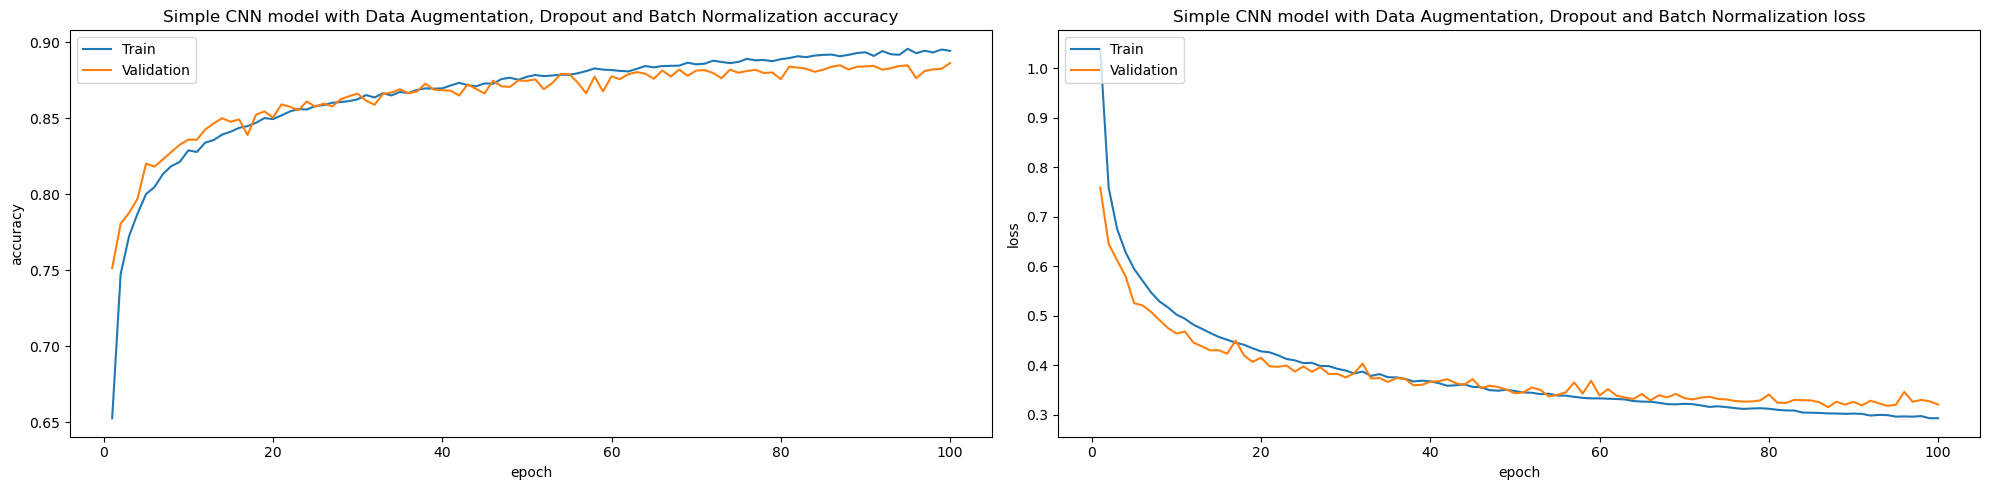

In [305]:
PlotTrainAndValidationAccuracyAndLoss(simple_cnn4_history, "Simple CNN model with Data Augmentation, Dropout and Batch Normalization")

313/313 - 1s - 5ms/step - accuracy: 0.8787 - loss: 0.3525

Test accuracy for Simple CNN 6: 0.8787

Test loss for Simple CNN 6: 0.3525

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
first 10 predicted outputs: [9 2 1 1 6 1 4 6 5 7]

first 10 true outpurs: [9 2 1 1 6 1 4 6 5 7]

Classification report for Simple CNN 6 :
              precision    recall  f1-score   support

           0       0.86      0.79      0.82      1000
           1       0.99      0.96      0.98      1000
           2       0.80      0.83      0.81      1000
           3       0.87      0.89      0.88      1000
           4       0.87      0.73      0.79      1000
           5       0.96      0.96      0.96      1000
           6       0.65      0.75      0.70      1000
           7       0.92      0.97      0.94      1000
           8       0.94      0.96      0.95      1000
           9       0.97      0.93      0.95      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88   

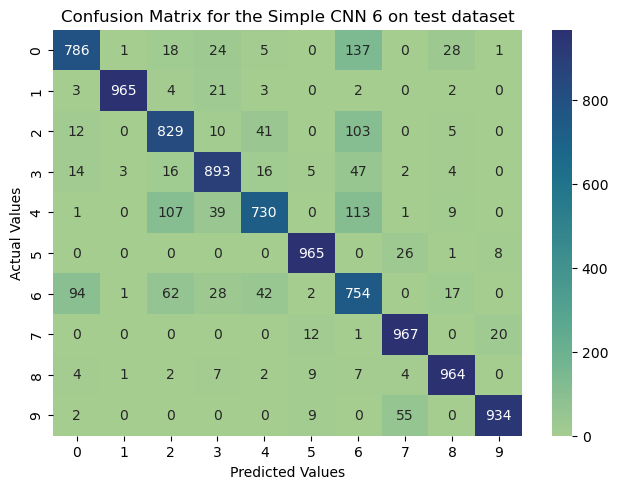

array([[6.4736523e-06, 8.2862389e-06, 3.0593768e-07, ..., 1.8771669e-02,
        3.4883962e-04, 9.3015164e-01],
       [2.0443997e-04, 3.5529456e-07, 9.9926621e-01, ..., 2.9502930e-06,
        2.8892572e-07, 4.9709030e-08],
       [2.8818738e-05, 9.9961120e-01, 1.6619018e-05, ..., 2.1899712e-07,
        3.7296406e-06, 5.8886367e-06],
       ...,
       [4.4615348e-03, 6.6374164e-06, 2.2945278e-04, ..., 1.1274270e-05,
        9.9424016e-01, 5.6765765e-07],
       [1.7967351e-06, 9.9973541e-01, 8.3941835e-08, ..., 9.8207693e-06,
        7.4953795e-07, 3.3976896e-05],
       [7.3741534e-04, 1.7318067e-05, 1.9558607e-05, ..., 6.0376924e-01,
        1.9857595e-02, 3.5515106e-03]], dtype=float32)

In [306]:
EvaluateNeuralNetworkModel(simple_cnn_model4, test_images, test_labels, test_labels_onehot, "Simple CNN 6")

### Simple CNN committee

Loss for the Simple Convolution neural network committee on test dataset: 0.2591
Accuracy for the Simple Convolution neural network committee on test dataset: 0.9149
first 10 predicted outputs using committee by averaging predictions: [9 2 1 1 6 1 4 6 5 7]

first 10 true outputs: [9 2 1 1 6 1 4 6 5 7]

              precision    recall  f1-score   support

           0       0.88      0.86      0.87      1000
           1       1.00      0.97      0.99      1000
           2       0.84      0.87      0.86      1000
           3       0.91      0.92      0.92      1000
           4       0.86      0.86      0.86      1000
           5       0.99      0.98      0.98      1000
           6       0.77      0.75      0.76      1000
           7       0.95      0.98      0.96      1000
           8       0.98      0.98      0.98      1000
           9       0.97      0.96      0.97      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91   

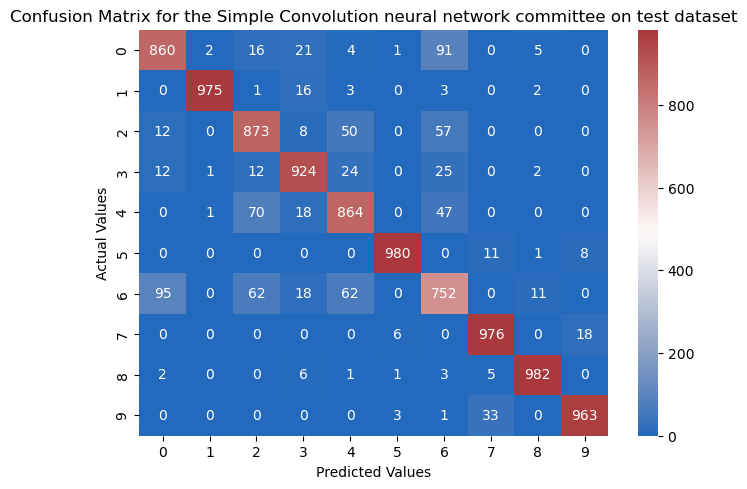

In [307]:
ModelCommitteeAnalysis(
    [simple_cnn1_prediction_result_softmax, 
     simple_cnn2_prediction_result_softmax, 
     simple_cnn3_prediction_result_softmax], 
    test_labels, "Simple Convolution")

## Deep Convolution Neural Network

### Deep CNN Model 1

- Two Convolutional layers
- Two Max pooling layers
- One Fully Connected layers
- One Output layer

**Model Architecture**
- Input layer accepts images of shape 28\*28\*1.
- First hidden layer uses Conv2D layer. It has 32 filters with kernel size of 3\*3. This layer uses ReLU as activation function. 
- Output from 1st convolution layer is passed into first max pooling layer. This layer uses pooling sizes of 2 \* 2.
- Output from first max pooling layer is then passed into the second convolutional layer. Second convolutional layer contains 128 filters with kernel size of 3 \* 3 and it also uses ReLU as activation function. 
- Second max pooling layer is used after second convolutional layer. It has pool size of 3* 3. 
- After that output from second max pooling layer is flattened first and then is fed into the fully connected layer. Fully connected layer contains 256 neurons and uses tanh activation function. 
- Output layer contains 10 neurons with activation function of softmax.


In [42]:
deep_cnn_model1 = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (28, 28, 1)),
    tf.keras.layers.Conv2D(filters= 32, kernel_size= (3, 3), activation= "relu"),
    tf.keras.layers.MaxPool2D(pool_size= (2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units= 256, activation= "tanh"),
    tf.keras.layers.Dense(10, activation='softmax')
])

deep_cnn_model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy,
              metrics=['accuracy'])

deep_cnn1_history = deep_cnn_model1.fit(train_images, train_labels_onehot, epochs=100, validation_split= 0.2, batch_size= 64)

Epoch 1/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.7800 - loss: 0.6016 - val_accuracy: 0.8814 - val_loss: 0.3314
Epoch 2/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.8839 - loss: 0.3213 - val_accuracy: 0.8922 - val_loss: 0.2996
Epoch 3/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9025 - loss: 0.2698 - val_accuracy: 0.9030 - val_loss: 0.2710
Epoch 4/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9171 - loss: 0.2311 - val_accuracy: 0.9035 - val_loss: 0.2700
Epoch 5/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9278 - loss: 0.2017 - val_accuracy: 0.9028 - val_loss: 0.2840
Epoch 6/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9353 - loss: 0.1744 - val_accuracy: 0.9035 - val_loss: 0.2967
Epoch 7/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9460 - loss: 0.1483 - val_accuracy: 0.9062 - val_loss: 0.2854
Epoch 8/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9556 - loss: 0.1238 - val_ac

In [43]:
deep_cnn_model1.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_11 (Conv2D)              │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 11, 11, 128)    │        36,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 256)            │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,578,016 (9.83 MB)

 Trainable params: 859,338 (3.28 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,718,678 (6.56 MB)

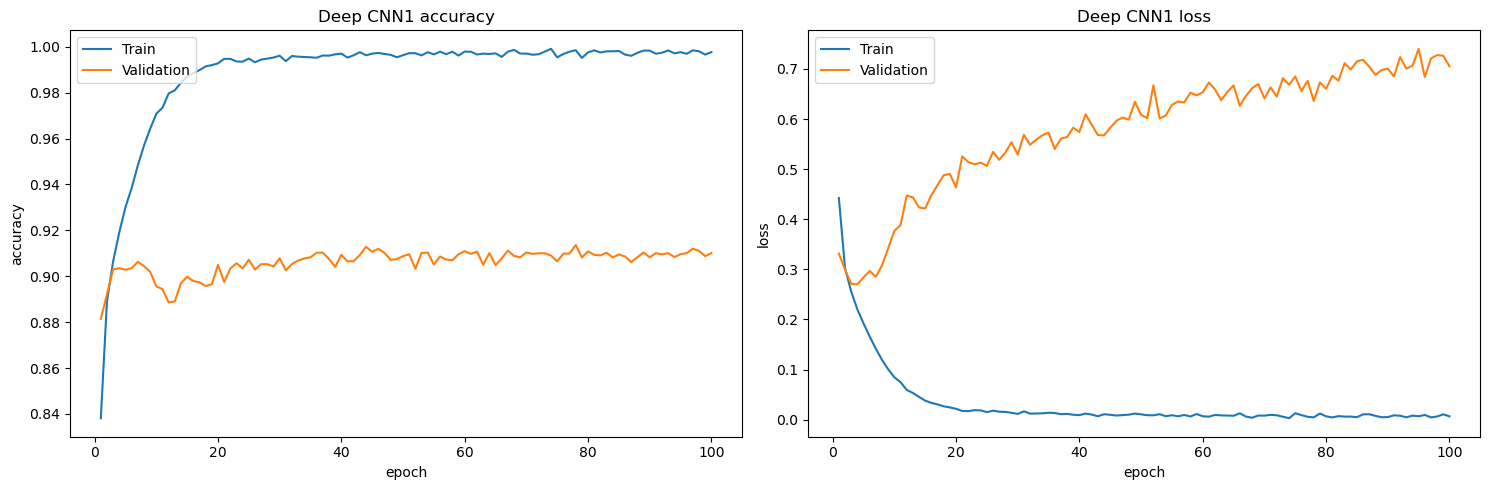

In [44]:
PlotTrainAndValidationAccuracyAndLoss(deep_cnn1_history, "Deep CNN1")

313/313 - 2s - 6ms/step - accuracy: 0.9081 - loss: 0.7541

Test accuracy for Deep CNN 1: 0.9081

Test loss for Deep CNN 1: 0.7541

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
first 10 predicted outputs: [9 2 1 1 6 1 4 6 5 7]

first 10 true outputs: [9 2 1 1 6 1 4 6 5 7]

Classification report for Deep CNN 1 :
              precision    recall  f1-score   support

           0       0.85      0.85      0.85      1000
           1       0.99      0.98      0.99      1000
           2       0.86      0.86      0.86      1000
           3       0.93      0.89      0.91      1000
           4       0.83      0.91      0.87      1000
           5       0.97      0.98      0.98      1000
           6       0.75      0.71      0.73      1000
           7       0.95      0.96      0.96      1000
           8       0.97      0.97      0.97      1000
           9       0.97      0.96      0.97      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.9

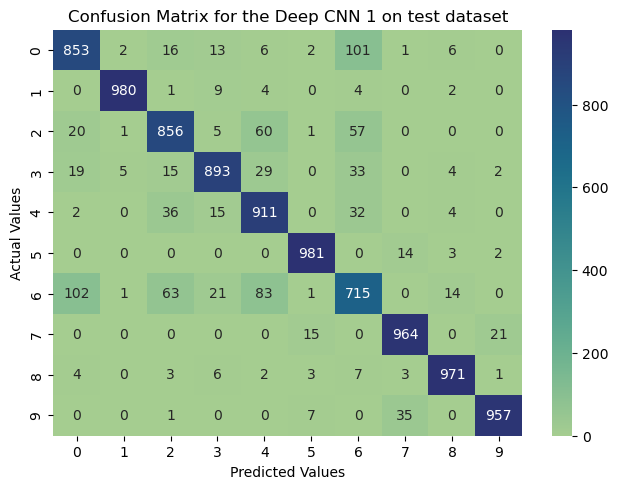

In [45]:
deep_cnn1_prediction_result_softmax = EvaluateNeuralNetworkModel(deep_cnn_model1, test_images, test_labels, test_labels_onehot, "Deep CNN 1")

### Deep CNN Model 2

**Model Architecture**
This model contains 3 convolutional layers and 3 max pooling layers and one fully connected layer. 
- First convolutional layer contains 32 filters with kernel size of 3 * 3 and ReLU activation function.
- Second convolutional layer contains 64 filters with kernel size of 3 * 3 and ReLU activation function.
- Third convolutional layer contains 128 filters with kernel size of 3 * 3 and ReLU activation function.
- All 3 max pooling layer has pool size of 2 * 2. 
- Fully connected layer has 256 neurons (nodes) with tanh activation function. 
- Output layer contains 10 nodes and softmax as activation function. 
- Adam Optimizer is used as optimization function. 
- Categorical cross entropy is used as loss function. 
- Model is trained upto 100 epochs with 20% of training records as validation data and with batch size of 64.

In [16]:
deep_cnn_model2 = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (28, 28, 1)),
    tf.keras.layers.Conv2D(filters= 32, kernel_size= (3, 3), activation= "relu"),
    tf.keras.layers.MaxPool2D(pool_size= (2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units= 256, activation= "tanh"),
    tf.keras.layers.Dense(10, activation='softmax')
])

deep_cnn_model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy,
              metrics=['accuracy'])

deep_cnn2_history = deep_cnn_model2.fit(train_images, train_labels_onehot, epochs=100, validation_split= 0.2, batch_size= 64)

Epoch 1/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.6997 - loss: 0.8262 - val_accuracy: 0.8438 - val_loss: 0.4291
Epoch 2/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8446 - loss: 0.4235 - val_accuracy: 0.8642 - val_loss: 0.3727
Epoch 3/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8678 - loss: 0.3612 - val_accuracy: 0.8714 - val_loss: 0.3522
Epoch 4/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8820 - loss: 0.3224 - val_accuracy: 0.8762 - val_loss: 0.3375
Epoch 5/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8914 - loss: 0.2907 - val_accuracy: 0.8807 - val_loss: 0.3339
Epoch 6/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9030 - loss: 0.2646 - val_accuracy: 0.8817 - val_loss: 0.3380
Epoch 7/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9118 - loss: 0.2392 - val_accuracy: 0.8851 - val_loss: 0.3352
Epoch 8/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9203 - loss: 0.2179 - val_accu

In [17]:
deep_cnn_model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 384,800 (1.47 MB)

 Trainable params: 128,266 (501.04 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 256,534 (1002.09 KB)

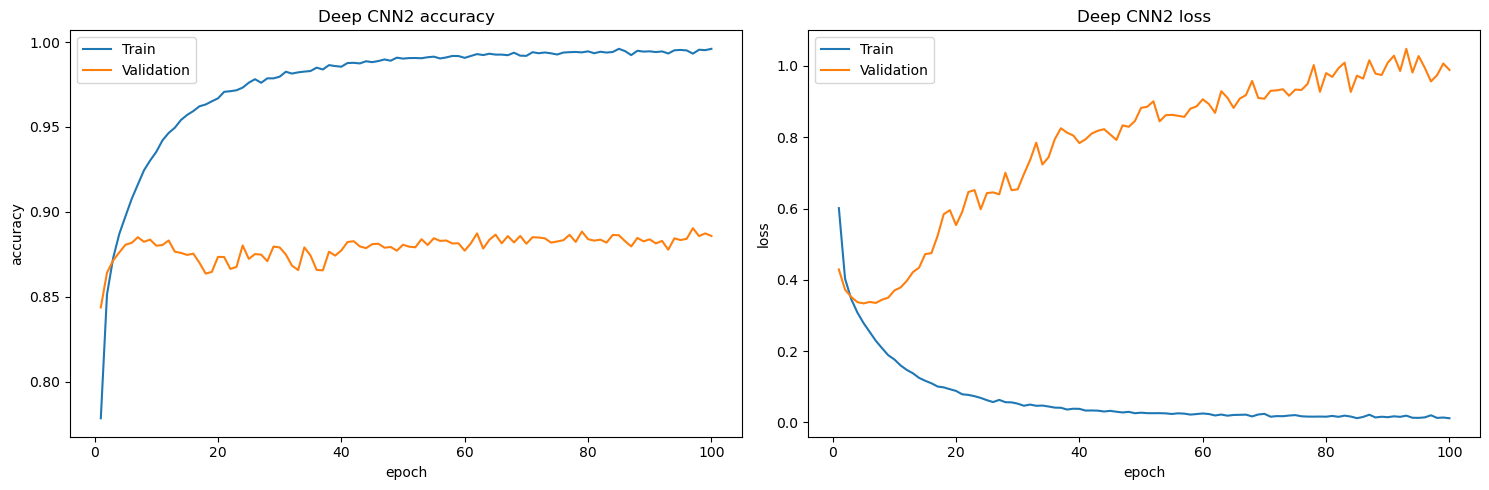

In [19]:
PlotTrainAndValidationAccuracyAndLoss(deep_cnn2_history, "Deep CNN2")

313/313 - 4s - 12ms/step - accuracy: 0.8815 - loss: 1.0584

Test accuracy for Deep CNN 2: 0.8815

Test loss for Deep CNN 2: 1.0584

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
first 10 predicted outputs: [9 2 1 1 4 1 4 6 5 7]

first 10 true outputs: [9 2 1 1 6 1 4 6 5 7]

Classification report for Deep CNN 2 :
              precision    recall  f1-score   support

           0       0.82      0.84      0.83      1000
           1       0.99      0.97      0.98      1000
           2       0.81      0.81      0.81      1000
           3       0.89      0.89      0.89      1000
           4       0.75      0.86      0.80      1000
           5       0.97      0.97      0.97      1000
           6       0.73      0.61      0.67      1000
           7       0.94      0.96      0.95      1000
           8       0.97      0.96      0.96      1000
           9       0.96      0.94      0.95      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.

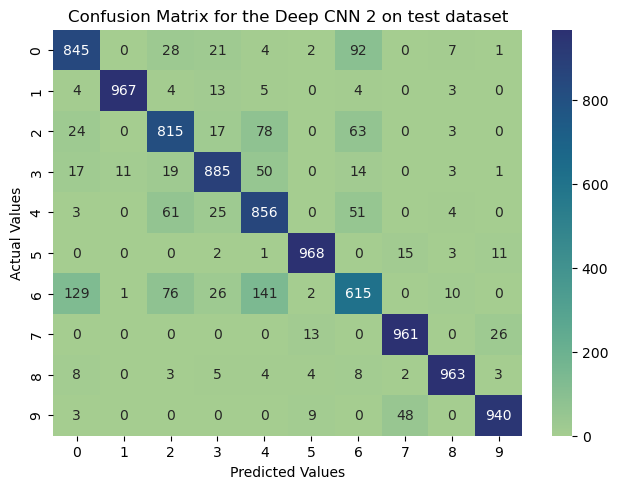

In [20]:
deep_cnn2_prediction_result_softmax = EvaluateNeuralNetworkModel(deep_cnn_model2, test_images, test_labels, test_labels_onehot, "Deep CNN 2")

### Deep CNN Model 3

**Model Architecture**
- This model contains 2 convolutional layers, two max-pooling layers, one fully connected layer and one output layer. 
- First Convolutional has 32 filters and kernel size of 3 * 3 with ReLU as activation function. 
- Second Convolution layer has 64 filters with kernel size of 3 * 3 and ReLU as activation function. 
- Two max pooling layers have same pool size of 2 * 2. 
- Fully connected layer has 256 neurons and tanh as activation function. 
- Output layer has 10 neurons and softmax as activation function. 
- SGD is used as optimization function with initial learning rate of 0.005.
-  Model is trained for 100 epochs with batch size of 64.

In [22]:
deep_cnn_model3 = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (28, 28, 1)),
    tf.keras.layers.Conv2D(filters= 32, kernel_size= (3, 3), activation= "relu"),
    tf.keras.layers.MaxPool2D(pool_size= (2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units= 256, activation= "tanh"),
    tf.keras.layers.Dense(10, activation='softmax')
])

deep_cnn_model3.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.005),
              loss=tf.keras.losses.CategoricalCrossentropy,
              metrics=['accuracy'])

deep_cnn3_history = deep_cnn_model3.fit(train_images, train_labels_onehot, epochs=100, validation_split= 0.2, batch_size= 64)

Epoch 1/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.4315 - loss: 1.8927 - val_accuracy: 0.7228 - val_loss: 0.8067
Epoch 2/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7116 - loss: 0.7873 - val_accuracy: 0.7579 - val_loss: 0.6746
Epoch 3/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7485 - loss: 0.6810 - val_accuracy: 0.7753 - val_loss: 0.6138
Epoch 4/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7691 - loss: 0.6213 - val_accuracy: 0.7887 - val_loss: 0.5721
Epoch 5/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7841 - loss: 0.5788 - val_accuracy: 0.7986 - val_loss: 0.5418
Epoch 6/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7963 - loss: 0.5465 - val_accuracy: 0.8092 - val_loss: 0.5187
Epoch 7/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8053 - loss: 0.5214 - val_accuracy: 0.8153 - val_loss: 0.4999
Epoch 8/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8131 - loss: 0.5007 - val_accu

In [23]:
deep_cnn_model3.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       409,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 431,244 (1.65 MB)

 Trainable params: 431,242 (1.65 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

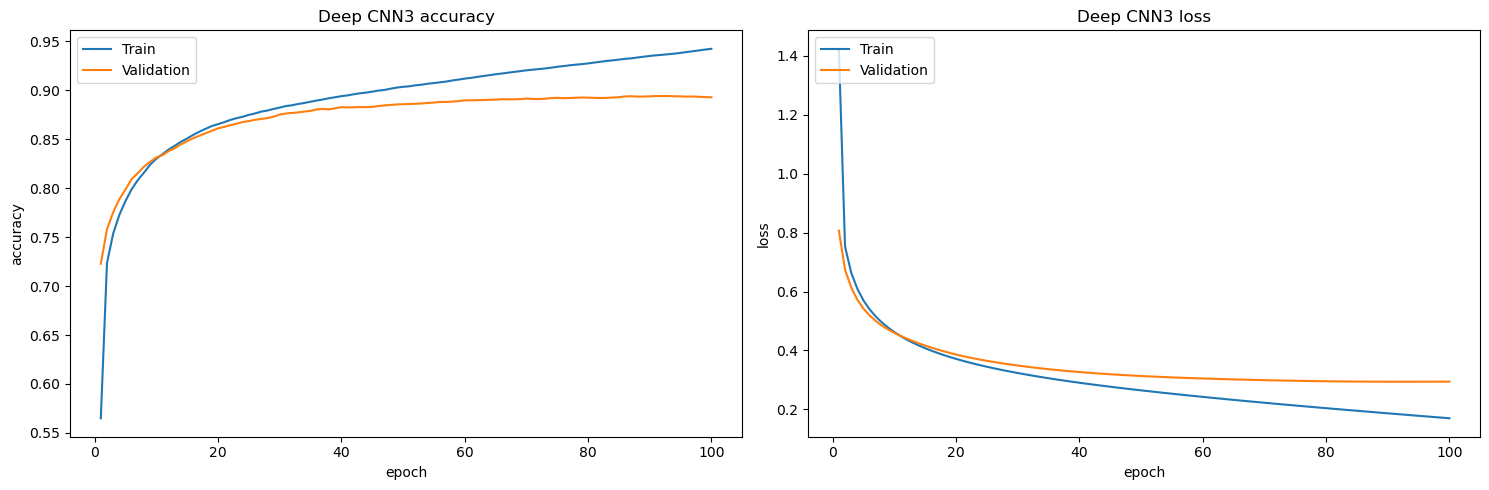

In [24]:
PlotTrainAndValidationAccuracyAndLoss(deep_cnn3_history, "Deep CNN3")

313/313 - 1s - 3ms/step - accuracy: 0.8906 - loss: 0.3059

Test accuracy for Deep CNN 3: 0.8906

Test loss for Deep CNN 3: 0.3059

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
first 10 predicted outputs: [9 2 1 1 6 1 4 6 5 7]

first 10 true outputs: [9 2 1 1 6 1 4 6 5 7]

Classification report for Deep CNN 3 :
              precision    recall  f1-score   support

           0       0.88      0.79      0.83      1000
           1       0.99      0.97      0.98      1000
           2       0.82      0.85      0.83      1000
           3       0.88      0.91      0.90      1000
           4       0.82      0.80      0.81      1000
           5       0.98      0.97      0.97      1000
           6       0.68      0.72      0.70      1000
           7       0.93      0.97      0.95      1000
           8       0.96      0.97      0.97      1000
           9       0.98      0.95      0.96      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.8

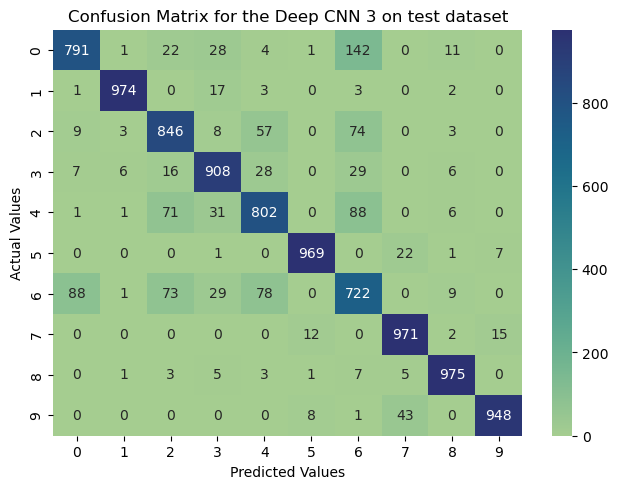

In [26]:
deep_cnn3_prediction_result_softmax = EvaluateNeuralNetworkModel(deep_cnn_model3, test_images, test_labels, test_labels_onehot, "Deep CNN 3")

## Committee of Models (Shallow Neural Network, Simple Convolutional Neural Network and Deep Convolutional Neural Network)

Loss for the Committee of Model neural network committee on test dataset: 0.2745
Accuracy for the Committee of Model neural network committee on test dataset: 0.9021
first 10 predicted outputs using committee by averaging predictions: [9 2 1 1 6 1 4 6 5 7]

first 10 true outputs: [9 2 1 1 6 1 4 6 5 7]

              precision    recall  f1-score   support

           0       0.91      0.80      0.85      1000
           1       0.99      0.97      0.98      1000
           2       0.82      0.87      0.84      1000
           3       0.88      0.91      0.90      1000
           4       0.86      0.82      0.84      1000
           5       0.98      0.97      0.97      1000
           6       0.72      0.77      0.74      1000
           7       0.94      0.97      0.95      1000
           8       0.97      0.98      0.97      1000
           9       0.98      0.95      0.97      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90   

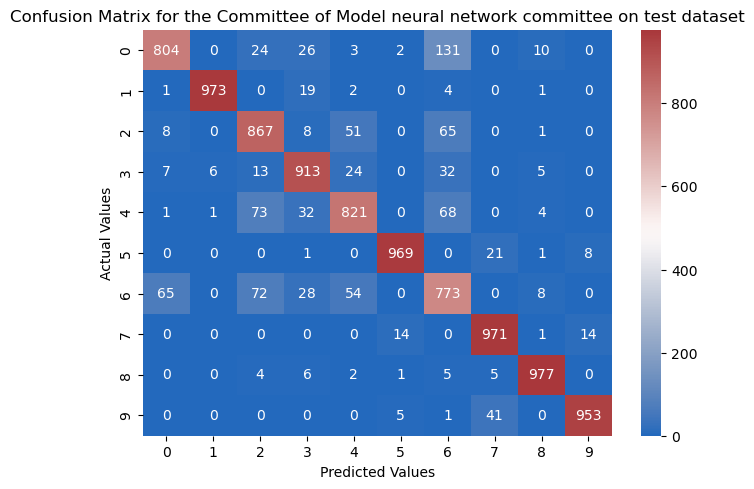

In [47]:
ModelCommitteeAnalysis(
    [snn3_prediction_result_softmax, 
     simple_cnn3_prediction_result_softmax, 
     deep_cnn3_prediction_result_softmax],
     test_labels,
     "Committee of Model"
)

## Extra Task: Data Augmentation, Dropout, and Batch Normalization

In [50]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels_onehot, test_size= 0.2, random_state= 42)

train_images_with_channel = tf.expand_dims(X_train, axis= -1)

data_augumentation = tf.keras.Sequential([
    #Data Augumentation 
    tf.keras.layers.RandomFlip(mode= "horizontal"),
    tf.keras.layers.RandomRotation(factor=0.2),
])

# # data_augumentation()
train_dataset = tf.data.Dataset.from_tensor_slices((train_images_with_channel, y_train))

# Shuffle, augment, batch, and prefetch the training data
batch_size = 64
train_dataset = (
    train_dataset
    .shuffle(buffer_size=1000)  # Shuffle the data
    .map(lambda x, y: (data_augumentation(x), y), num_parallel_calls=tf.data.AUTOTUNE)  # Apply augmentation
    .batch(batch_size)  # Batch the data
    .prefetch(buffer_size=tf.data.AUTOTUNE)  # Prefetch for performance
)


In [52]:
nn_model_with_data_aug = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (28, 28, 1)),
    tf.keras.layers.Conv2D(filters= 32, kernel_size= (3, 3), activation= "relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size= (2, 2)),
    tf.keras.layers.Dropout(0.05),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units= 256, activation= "tanh"),
    tf.keras.layers.Dense(10, activation='softmax')
])

nn_model_with_data_aug.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
              loss=tf.keras.losses.CategoricalCrossentropy,
              metrics=['accuracy'])

nn_model_with_data_aug_history = nn_model_with_data_aug.fit(train_dataset , epochs=100, validation_data= (X_val, y_val), batch_size= 64)

Epoch 1/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 18s 17ms/step - accuracy: 0.6295 - loss: 1.0884 - val_accuracy: 0.6477 - val_loss: 0.9789
Epoch 2/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.7285 - loss: 0.7421 - val_accuracy: 0.7097 - val_loss: 0.7886
Epoch 3/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.7478 - loss: 0.6938 - val_accuracy: 0.7149 - val_loss: 0.8056
Epoch 4/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.7586 - loss: 0.6798 - val_accuracy: 0.7327 - val_loss: 0.7355
Epoch 5/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.7633 - loss: 0.6615 - val_accuracy: 0.7548 - val_loss: 0.6661
Epoch 6/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.7730 - loss: 0.6328 - val_accuracy: 0.7458 - val_loss: 0.7014
Epoch 7/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.7789 - loss: 0.6169 - val_accuracy: 0.7822 - val_loss: 0.6187
Epoch 8/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 26s 34ms/step - accuracy: 0.7789 - loss: 0.619

In [55]:
nn_model_with_data_aug.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_13 (Conv2D)              │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 26, 26, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 11, 11, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 256)            │       409,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,294,496 (4.94 MB)

 Trainable params: 431,434 (1.65 MB)

 Non-trainable params: 192 (768.00 B)

 Optimizer params: 862,870 (3.29 MB)

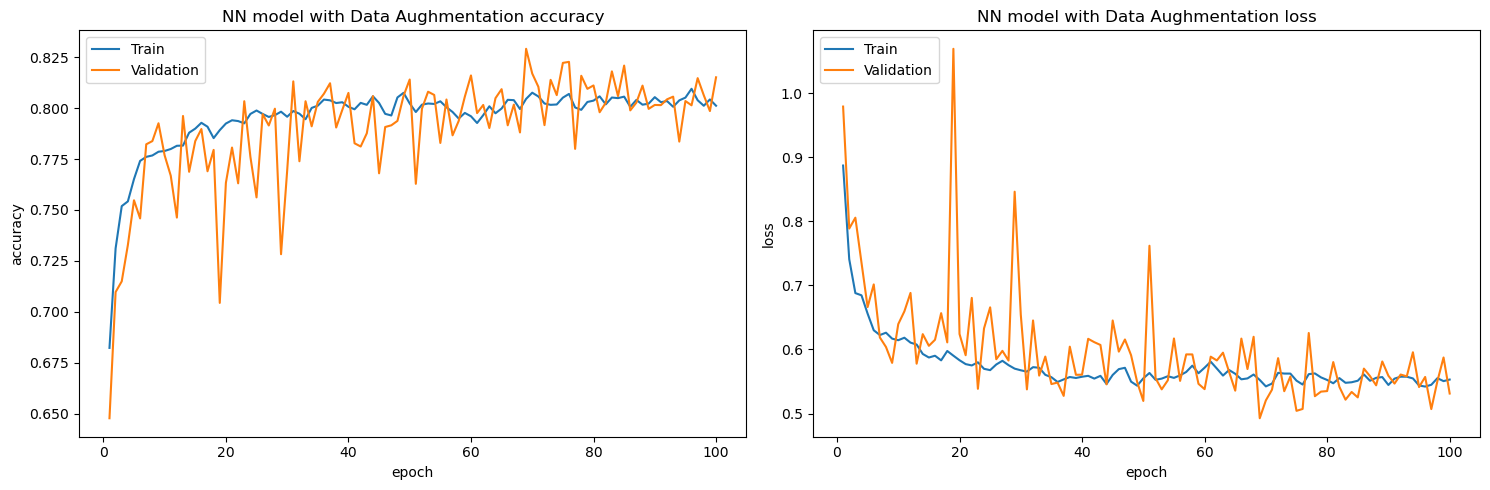

In [53]:
PlotTrainAndValidationAccuracyAndLoss(nn_model_with_data_aug_history, "NN model with Data Aughmentation")

313/313 - 1s - 4ms/step - accuracy: 0.8103 - loss: 0.5517

Test accuracy for NN model with data augmentation, dropout and batch normalization: 0.8103

Test loss for NN model with data augmentation, dropout and batch normalization: 0.5517

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
first 10 predicted outputs: [9 2 1 1 6 1 6 4 5 7]

first 10 true outputs: [9 2 1 1 6 1 4 6 5 7]

Classification report for NN model with data augmentation, dropout and batch normalization :
              precision    recall  f1-score   support

           0       0.80      0.68      0.73      1000
           1       0.98      0.93      0.96      1000
           2       0.71      0.73      0.72      1000
           3       0.75      0.90      0.82      1000
           4       0.71      0.71      0.71      1000
           5       0.93      0.90      0.92      1000
           6       0.55      0.51      0.53      1000
           7       0.82      0.96      0.88      1000
           8       0.91      0.94      0.92

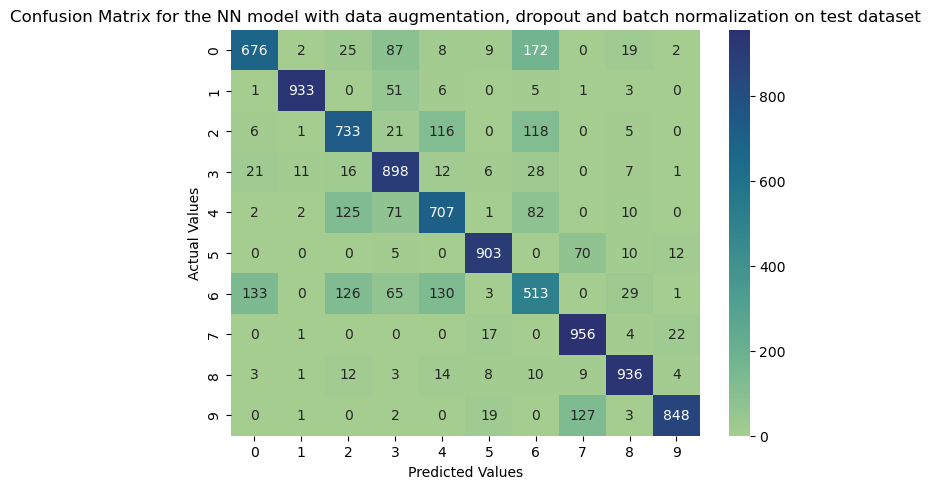

In [54]:
nn_model_softmax = EvaluateNeuralNetworkModel(nn_model_with_data_aug, test_images, test_labels, test_labels_onehot, "NN model with data augmentation, dropout and batch normalization")

## Please use the Fashion MNIST dataset in Q1 to implement the following network along with batch normalization and dropout layers.

### ANN Model with Concatenation (input layer and dense layer)

**Model Architecture**
- Input layer accepts gray scale image of size 28 * 28 pixels. 
- Received input is flattened and passed to 1st dense layer. 
- First dense layer contains 256 neurons with ReLU as activation function and output is passed to second dense layer as input. 
- second dense layer contains 784 neurons and ReLU activation function. 
- Second dense layer's output is then reshaped into 28 * 28 * 1 shape to match to the shape of input. 
- Input is then concatenated with the sencond dense layer's output. 
- After concatenation, output is then flattened and passed into the fully connected layer. 
- Fully connected layer contains 256 neurons and ReLU activation function. 
- Finally, Fully connected layer is connected with output layer and output layer contains 10 neurons and "Softmax" as activation function. 
- For optimization, We are using Adam Optimizer with initial learning rate of 0.005. 
- For loss calculation, we use Categorical Cross Entropy. 

In [16]:
# ann_model = tf.keras.Sequential()
input_layer = tf.keras.layers.Input(shape = (28, 28, 1))
flatten_layer = tf.keras.layers.Flatten()(input_layer)
dense_layer1 = tf.keras.layers.Dense(units= 256, activation=  "relu")(flatten_layer)
dense_layer2 = tf.keras.layers.Dense(units= 784, activation=  "relu")(dense_layer1)
dense_layer2_reshaped = tf.keras.layers.Reshape(target_shape=(28, 28, 1))(dense_layer2)
concatenated_layer = tf.keras.layers.Concatenate(axis=-1)([input_layer, dense_layer2_reshaped])
flatten_layer2 = tf.keras.layers.Flatten()(concatenated_layer)
fully_connected_layer = tf.keras.layers.Dense(units= 256, activation= "relu")(flatten_layer)
output_layer = tf.keras.layers.Dense(10, activation='softmax')(fully_connected_layer)

ann_model = tf.keras.Model(
    input_layer,
    output_layer
)

ann_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
              loss=tf.keras.losses.CategoricalCrossentropy,
              metrics=['accuracy'])

ann_model_history = ann_model.fit(train_images, train_labels_onehot , epochs=100, validation_split= 0.2, batch_size= 64)

Epoch 1/100


I0000 00:00:1732645242.258240    7573 service.cc:146] XLA service 0x774980005080 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732645242.258269    7573 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2024-11-26 12:20:42.307403: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-26 12:20:42.693253: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


 53/750 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5474 - loss: 1.2617

I0000 00:00:1732645243.911351    7573 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.7742 - loss: 0.6334 - val_accuracy: 0.8448 - val_loss: 0.4301
Epoch 2/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8546 - loss: 0.4009 - val_accuracy: 0.8619 - val_loss: 0.3851
Epoch 3/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8685 - loss: 0.3605 - val_accuracy: 0.8608 - val_loss: 0.3894
Epoch 4/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8775 - loss: 0.3394 - val_accuracy: 0.8641 - val_loss: 0.3893
Epoch 5/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8842 - loss: 0.3195 - val_accuracy: 0.8733 - val_loss: 0.3674
Epoch 6/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8864 - loss: 0.3063 - val_accuracy: 0.8685 - val_loss: 0.3829
Epoch 7/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8911 - loss: 0.2949 - val_accuracy: 0.8658 - val_loss: 0.3918
Epoch 8/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8930 - loss: 0.2860 - val_accuracy: 0.8647

In [19]:
ann_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 610,592 (2.33 MB)

 Trainable params: 203,530 (795.04 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 407,062 (1.55 MB)

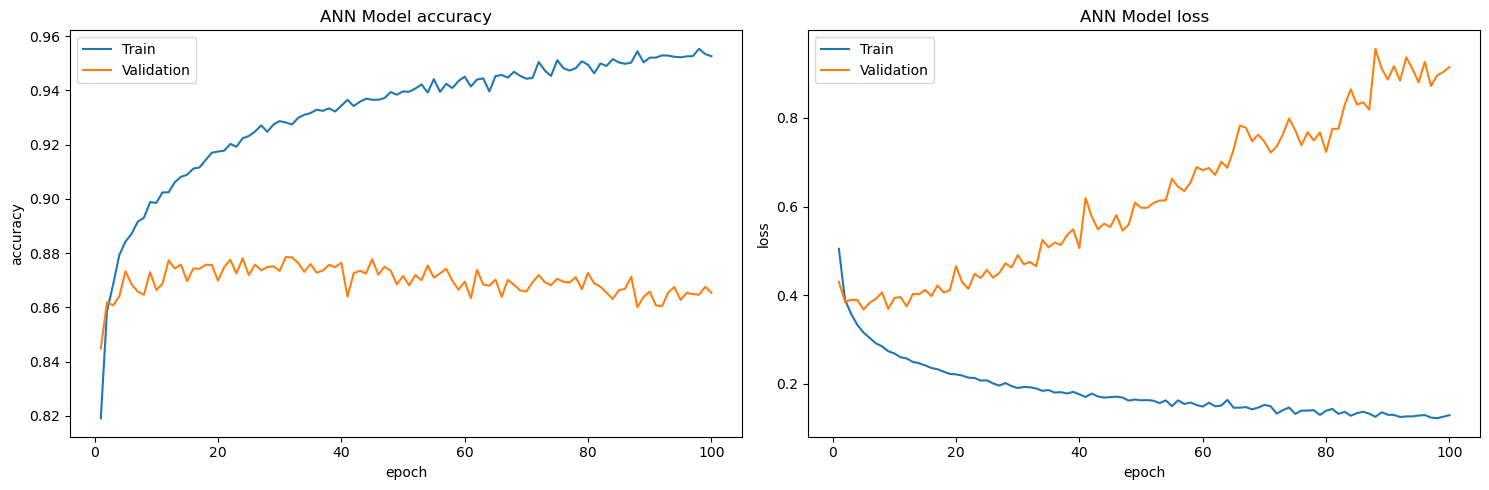

In [17]:
PlotTrainAndValidationAccuracyAndLoss(ann_model_history, "ANN Model")

313/313 - 0s - 725us/step - accuracy: 0.8612 - loss: 0.9804

Test accuracy for ANN Model with concatenation: 0.8612

Test loss for ANN Model with concatenation: 0.9804

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step
first 10 predicted outputs: [9 2 1 1 6 1 4 6 5 7]

first 10 true outputs: [9 2 1 1 6 1 4 6 5 7]

Classification report for ANN Model with concatenation :
              precision    recall  f1-score   support

           0       0.84      0.71      0.77      1000
           1       0.99      0.96      0.98      1000
           2       0.79      0.79      0.79      1000
           3       0.84      0.89      0.86      1000
           4       0.80      0.74      0.77      1000
           5       0.97      0.96      0.96      1000
           6       0.59      0.73      0.65      1000
           7       0.92      0.96      0.94      1000
           8       0.98      0.95      0.97      1000
           9       0.96      0.93      0.94      1000

    accuracy                          

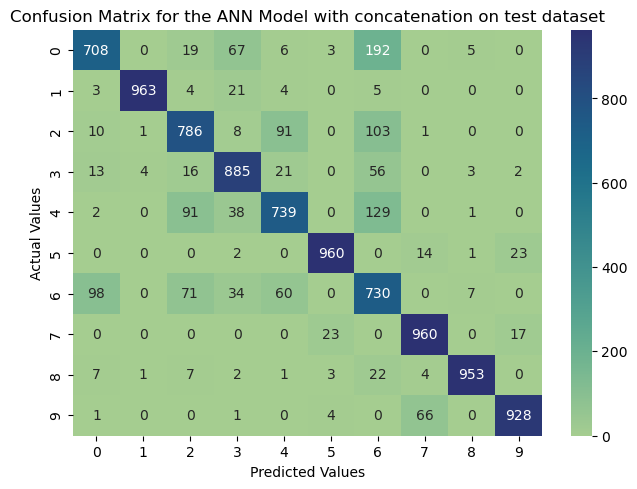

array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 7.1981371e-10,
        0.0000000e+00, 1.0000000e+00],
       [4.8971747e-12, 0.0000000e+00, 9.9999952e-01, ..., 0.0000000e+00,
        2.7242101e-36, 0.0000000e+00],
       [0.0000000e+00, 1.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       ...,
       [4.2038954e-45, 0.0000000e+00, 3.0828566e-44, ..., 0.0000000e+00,
        1.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 1.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        3.5290665e-35, 0.0000000e+00],
       [1.3346094e-23, 5.1632293e-17, 1.7277943e-20, ..., 7.7411155e-17,
        7.0974089e-08, 1.9571830e-20]], dtype=float32)

In [30]:
EvaluateNeuralNetworkModel(ann_model, test_images, test_labels, test_labels_onehot, "ANN Model with concatenation")

### ANN model with concatenation, dropout and batch normalization

**Model Architecture**
- Input layer accepts gray scale image of size 28 * 28 pixels. 
- Received input is flattened and passed to 1st dense layer. 
- First dense layer contains 256 neurons with ReLU as activation function and output is passed to batch normalization.
- Normalized outputs are then passed into second dense layer as input. 
- second dense layer contains 784 neurons and ReLU activation function. 
- Second dense layer's output is then again passed through second batch normalization. 
- Output from second batch normalization is then reshaped into 28 * 28 * 1 shape to match to the shape of input. 
- Input is then concatenated with the sencond dense layer's output. 
- After concatenation, model is then passed to the dropout layer to randomly reset the weights in fraction of neurons.
- After dropout, output is then flattened and passed into the fully connected layer. 
- Fully connected layer contains 256 neurons and ReLU activation function. 
- Finally, Fully connected layer is connected with output layer and output layer contains 10 neurons and "Softmax" as activation function. 
- For optimization, We are using Adam Optimizer with initial learning rate of 0.005. 
- For loss calculation, we use Categorical Cross Entropy. 

In [29]:
# ann_model = tf.keras.Sequential()
input_layer_model2 = tf.keras.layers.Input(shape = (28, 28,1))
flatten_layer_model2 = tf.keras.layers.Flatten()(input_layer_model2)
dense_layer1_model2 = tf.keras.layers.Dense(units= 256, activation=  "relu")(flatten_layer_model2)
batch_normalization1_model2 = tf.keras.layers.BatchNormalization()(dense_layer1_model2)
dense_layer2_model2 = tf.keras.layers.Dense(units= 784, activation=  "relu")(batch_normalization1_model2)
batch_normalization2_model2 = tf.keras.layers.BatchNormalization()(dense_layer2_model2)
dense_layer2_reshaped_model2 = tf.keras.layers.Reshape(target_shape=(28, 28, 1))(batch_normalization2_model2)
concatenated_layer_model2 = tf.keras.layers.Concatenate(axis=-1)([input_layer_model2, dense_layer2_reshaped_model2])
dropout_layer_model2 = tf.keras.layers.Dropout(0.05)(concatenated_layer_model2)
flatten_layer2_model2 = tf.keras.layers.Flatten()(dropout_layer_model2)
fully_connected_layer_model2 = tf.keras.layers.Dense(units= 256, activation= "relu")(flatten_layer2_model2)
output_layer_model2 = tf.keras.layers.Dense(10, activation='softmax')(fully_connected_layer_model2)

ann_model2 = tf.keras.Model(
    input_layer_model2,
    output_layer_model2
)

ann_model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
              loss=tf.keras.losses.CategoricalCrossentropy,
              metrics=['accuracy'])

ann_model2_history = ann_model2.fit(train_images, train_labels_onehot , epochs=100, validation_split= 0.2, batch_size= 64)

Epoch 1/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.7669 - loss: 0.6984 - val_accuracy: 0.8487 - val_loss: 0.4243
Epoch 2/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8497 - loss: 0.4171 - val_accuracy: 0.8474 - val_loss: 0.4261
Epoch 3/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8636 - loss: 0.3745 - val_accuracy: 0.8498 - val_loss: 0.4311
Epoch 4/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8731 - loss: 0.3466 - val_accuracy: 0.8555 - val_loss: 0.4367
Epoch 5/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8810 - loss: 0.3265 - val_accuracy: 0.8660 - val_loss: 0.4291
Epoch 6/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8858 - loss: 0.3126 - val_accuracy: 0.8530 - val_loss: 0.4402
Epoch 7/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8909 - loss: 0.2981 - val_accuracy: 0.8662 - val_loss: 0.3864
Epoch 8/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8925 - loss: 0.2864 - val_acc

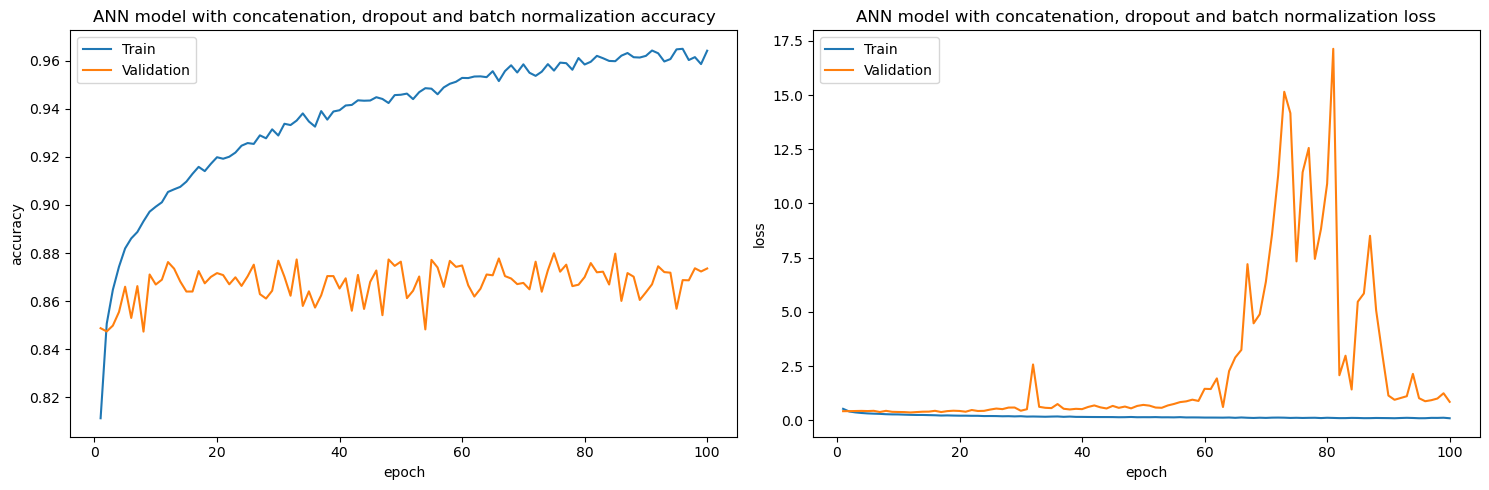

In [31]:
PlotTrainAndValidationAccuracyAndLoss(ann_model2_history, "ANN model with concatenation, dropout and batch normalization")

313/313 - 1s - 2ms/step - accuracy: 0.8653 - loss: 2.2153

Test accuracy for ANN model with concatenation, dropout and batch normalization: 0.8653

Test loss for ANN model with concatenation, dropout and batch normalization: 2.2153

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
first 10 predicted outputs: [9 2 1 1 6 1 4 6 5 7]

first 10 true outputs: [9 2 1 1 6 1 4 6 5 7]

Classification report for ANN model with concatenation, dropout and batch normalization :
              precision    recall  f1-score   support

           0       0.80      0.82      0.81      1000
           1       0.97      0.97      0.97      1000
           2       0.75      0.82      0.78      1000
           3       0.91      0.81      0.86      1000
           4       0.83      0.72      0.77      1000
           5       0.97      0.95      0.96      1000
           6       0.62      0.71      0.66      1000
           7       0.92      0.96      0.94      1000
           8       0.98      0.94      0.96      100

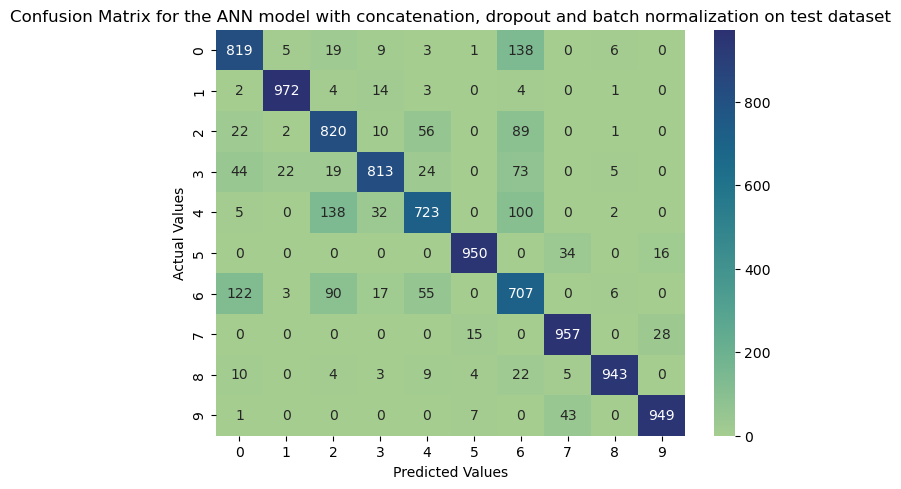

array([[9.4365470e-31, 0.0000000e+00, 0.0000000e+00, ..., 2.6772088e-05,
        2.5772317e-38, 9.9997318e-01],
       [6.9211920e-10, 1.4679005e-18, 9.9999988e-01, ..., 0.0000000e+00,
        1.9968713e-30, 0.0000000e+00],
       [0.0000000e+00, 1.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       ...,
       [0.0000000e+00, 0.0000000e+00, 2.9928184e-35, ..., 7.6205844e-23,
        1.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 1.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 2.0313954e-34, ..., 3.0985662e-15,
        8.1987628e-18, 2.5920939e-40]], dtype=float32)

In [34]:
EvaluateNeuralNetworkModel(ann_model2, test_images, test_labels, test_labels_onehot, "ANN model with concatenation, dropout and batch normalization")